In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import jensenshannon
import geopandas as gpd

from PopSynthesis.Methods.connect_HH_PP.paras_dir import processed_data, output_dir, data_dir
from PopSynthesis.Methods.connect_HH_PP.scripts.utils import convert_full_to_marg_count

In [2]:
font = {'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)

geo_lev = "POA"

In [3]:
syn_hh_saa = pd.read_csv(os.path.join(output_dir,"new_test", f"syn_hh_final_POA_ad5.csv"))
# syn_hh_ipf = pd.read_csv(os.path.join(output_dir, "IPF_re_HH_only.csv"))
syn_hh_ipf = pd.read_csv(os.path.join(output_dir, "new_test","syn_hh_ipu.csv"))
syn_hh_bn = pd.read_csv(os.path.join(output_dir, "new_test", f"hh_no_adjustments.csv"))

In [4]:
syn_hh_saa = syn_hh_saa.astype(str)
syn_hh_ipf = syn_hh_ipf.astype(str)
syn_hh_bn = syn_hh_bn.astype(str)

In [5]:
# syn_hh_ipf = syn_hh_ipf.rename(columns={"zone": geo_lev})
syn_hh_ipf = syn_hh_ipf.rename(columns={"geog": geo_lev})
syn_hh_ipf["hhid"] = syn_hh_ipf.index
syn_hh_ipf = syn_hh_ipf[syn_hh_ipf["hhinc"]!="Negative income"]

In [6]:
marg_hh = pd.read_csv(os.path.join(data_dir,f"hh_marginals_ipu.csv"), header=[0,1])

In [7]:
hold = marg_hh.columns[marg_hh.columns.get_level_values(0)=="zone_id"]
marg_hh = marg_hh.set_index(hold[0])
marg_hh.index.name = geo_lev
marg_hh = marg_hh.drop(columns=list(marg_hh.columns[marg_hh.columns.get_level_values(0).isin(["sample_geog", "zone_id"])]))
marg_hh

hhsize                                          dwelltype          ...  \
          1     2     3    4    5   6  7  8+ Flat or Apartment Missing  ...   
POA                                                                     ...   
3000  10393  8524  2026  656  118  27  4  58             21546     128  ...   
3002   1035  1019   190  101   38   9  0  55              1877       9  ...   
3003   1504  1591   476  223   40  11  7  55              3187       6  ...   
3004   2566  2382   511  227   33   6  5  55              5741      27  ...   
3006   5113  5033  1280  414   59  13  8  58             11783      40  ...   
...     ...   ...   ...  ...  ...  .. ..  ..               ...     ...  ...   
3990      6    20     8    4    3   0  0  55                 0       0  ...   
3991     37    65    16   19   10   9  0  55                 0       0  ...   
3992    134   201    72   60   24   9  0  55                 0       0  ...   
3995   1663  1834   629  451  228  73  8  58                25       8  ...   
3996    806  1176   251  299  137  31  6  59                12       4  ...   

          hhinc totalvehs                              owndwell               \
     Nil income         0     1     2    3   4+ Being Purchased Being Rented   
POA                                                                            
3000       1916     14688  5445   861  397  415            2453        16601   
3002         42       478  1268   545   89   67             434         1298   
3003        159      1401  1937   420   93   56             797         2548   
3004        172      1198  3442   882  168   95            1207         3212   
3006        435      4725  5884  1026  193  150            2136         8092   
...         ...       ...   ...   ...  ...  ...             ...          ...   
3990          3        13    12    30   25   16              16            0   
3991          6        20    46    66   42   37              51           17   
3992          9        12   153   218   93   79             229           55   
3995         87       380  1949  1692  585  338            1326         1150   
3996         55        88  1040  1207  298  132             690          494   

                                 
     Fully Owned Something Else  
POA                              
3000        2284            468  
3002         673             42  
3003         463             99  
3004        1268             98  
3006        1537            213  
...          ...            ...  
3990          22             58  
3991          67             76  
3992         192             79  
3995        2316            152  
3996        1525             56  

[691 rows x 44 columns]

In [8]:
# Polynomial Regression
def r_squared(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_176\984278662.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (10, 5))
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_176\1836707500.py:17: RuntimeWarning: invalid value encountered in scalar divide
  results['determination'] = ssreg / sstot


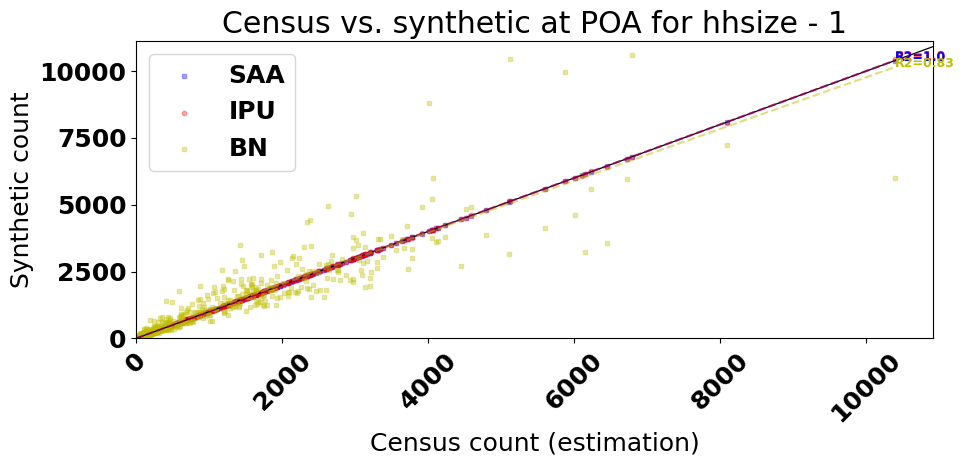

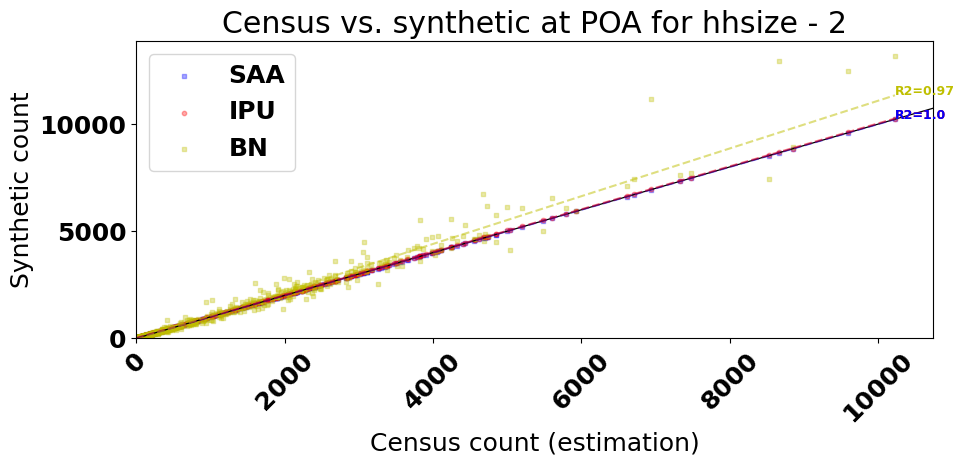

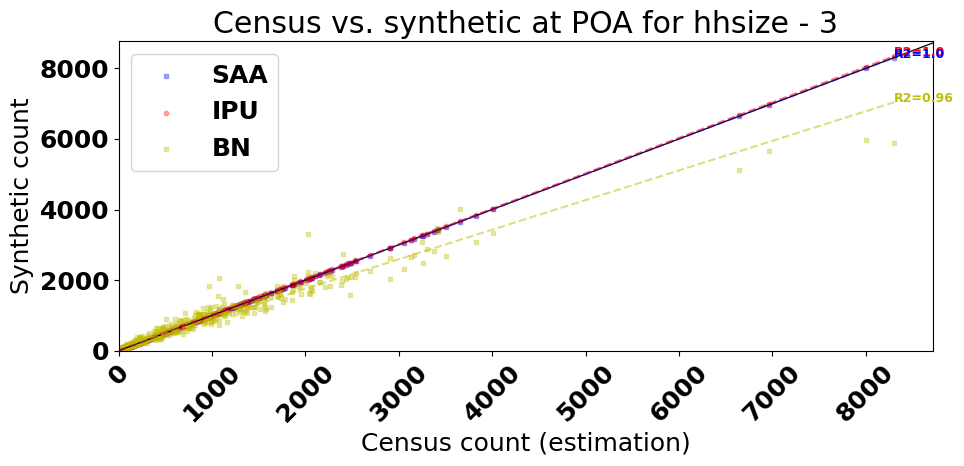

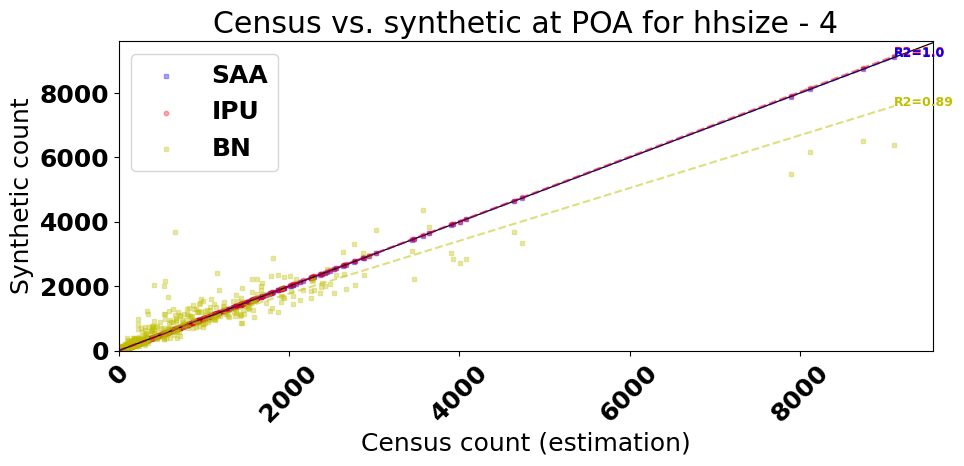

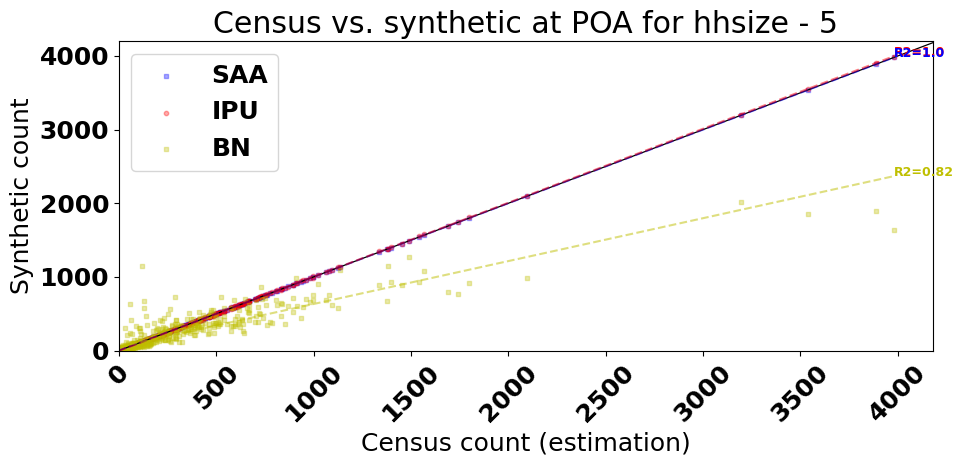

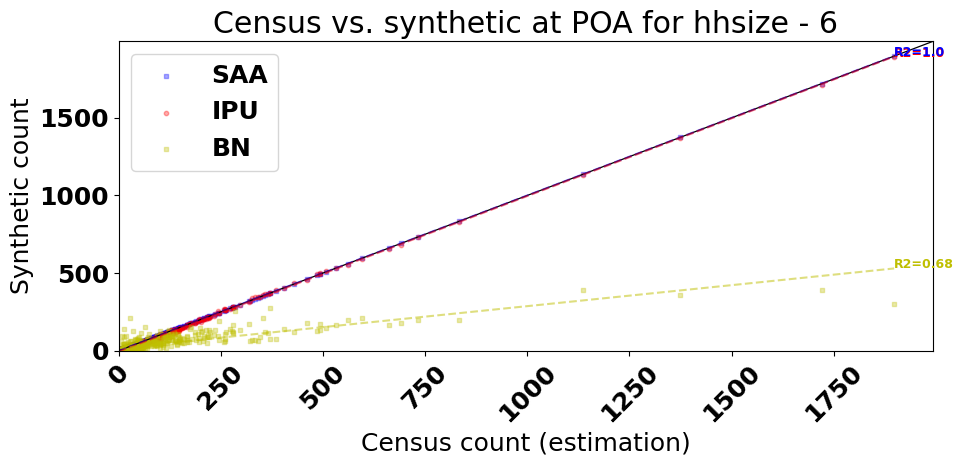

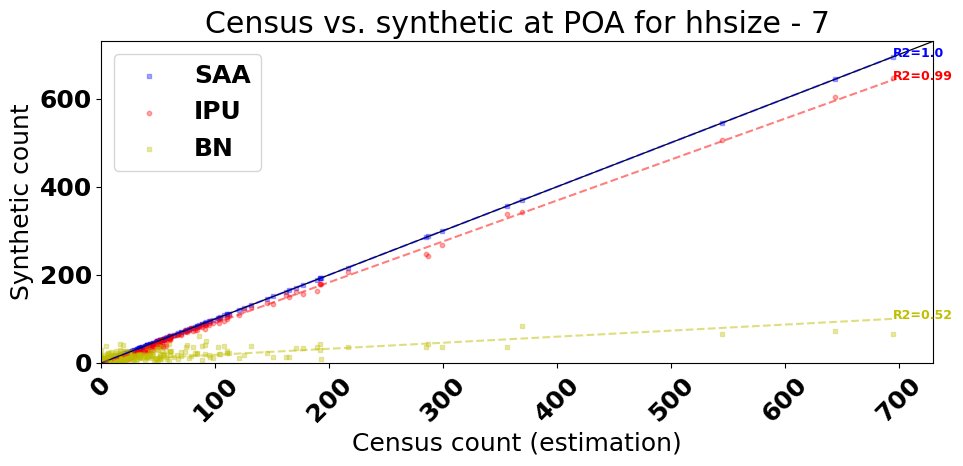

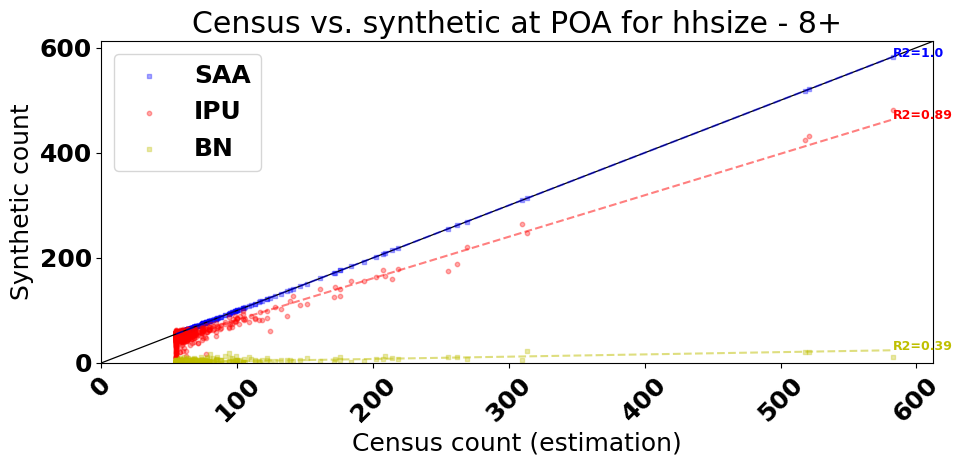

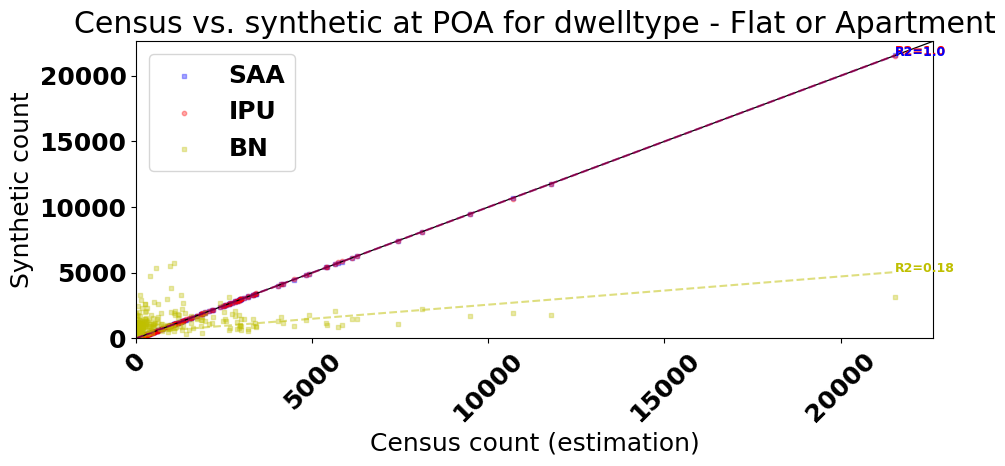

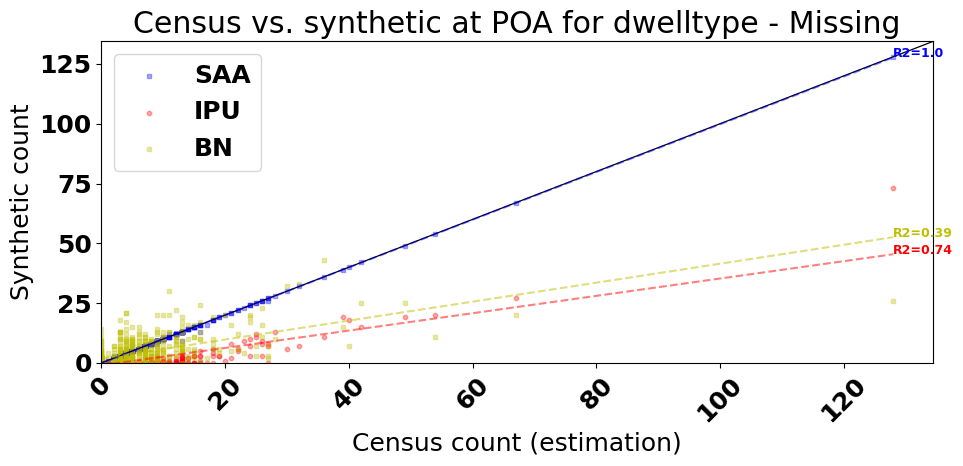

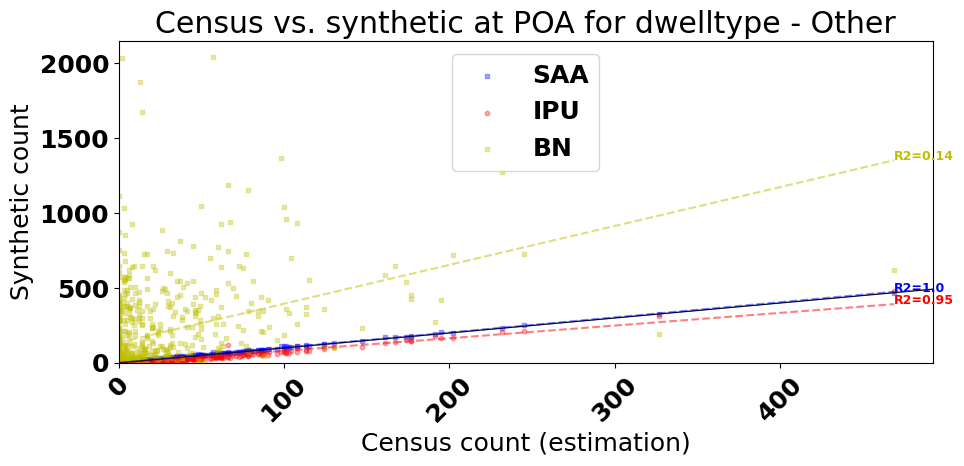

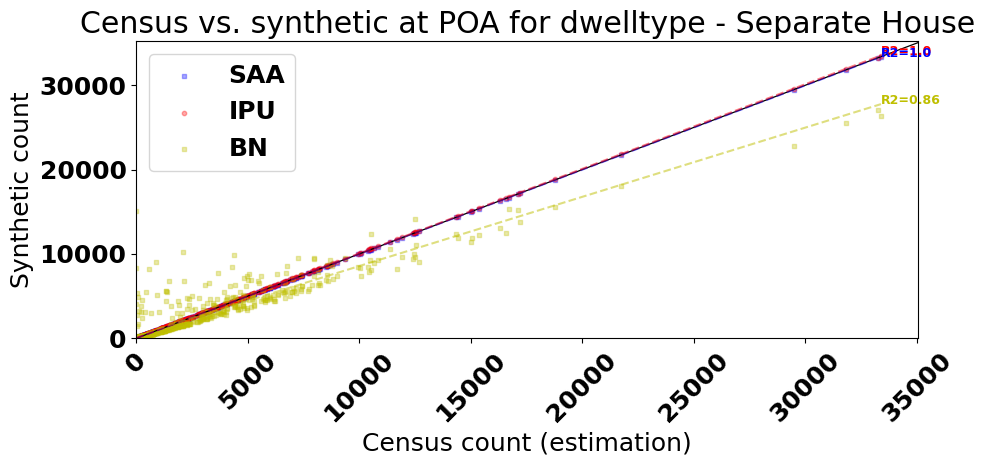

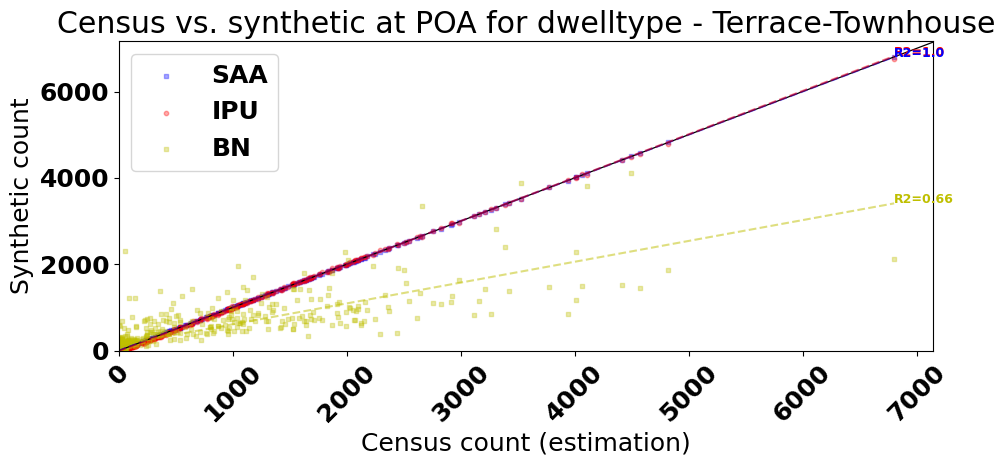

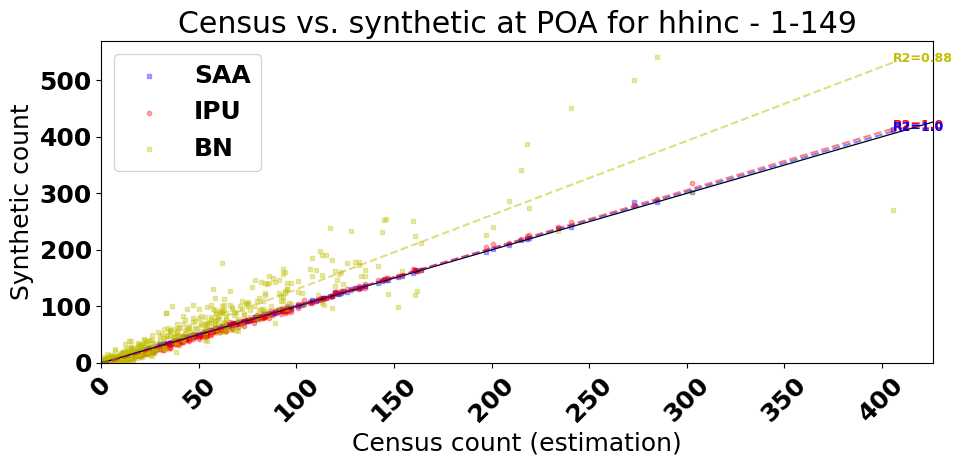

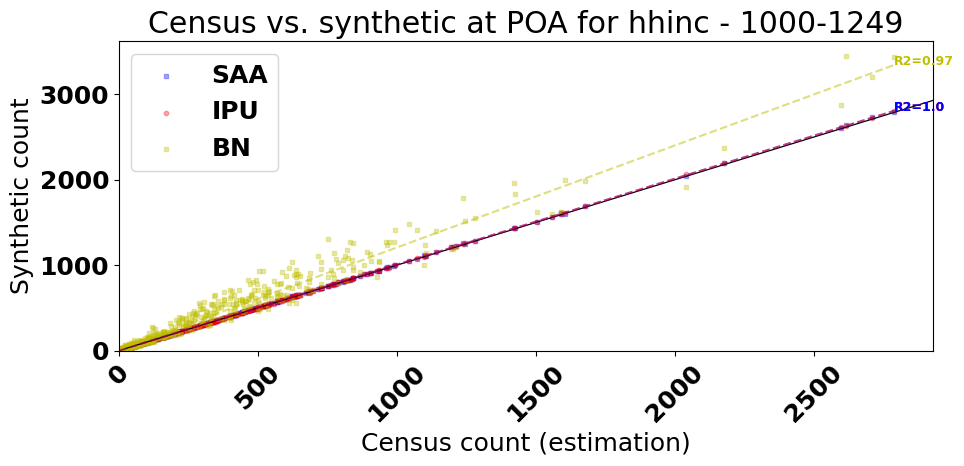

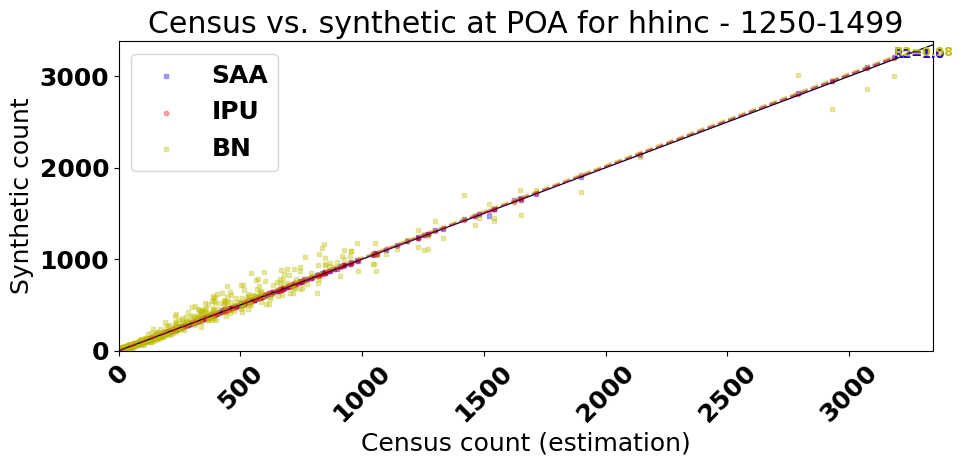

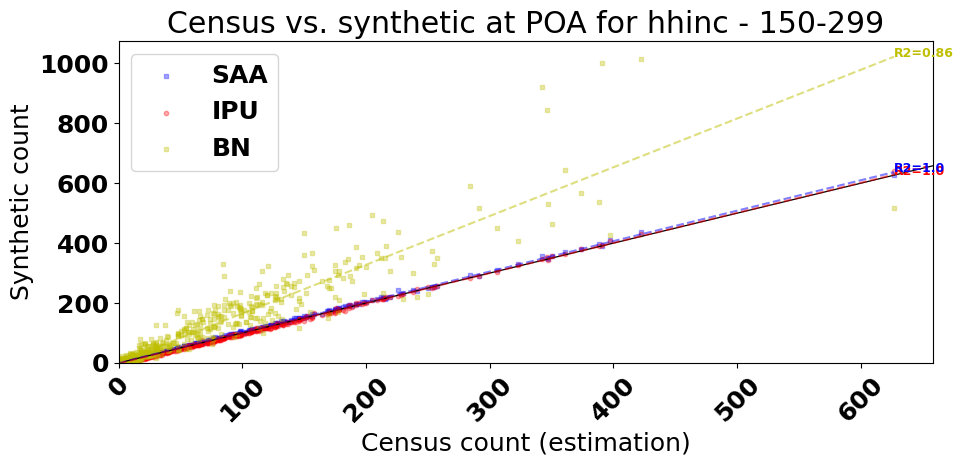

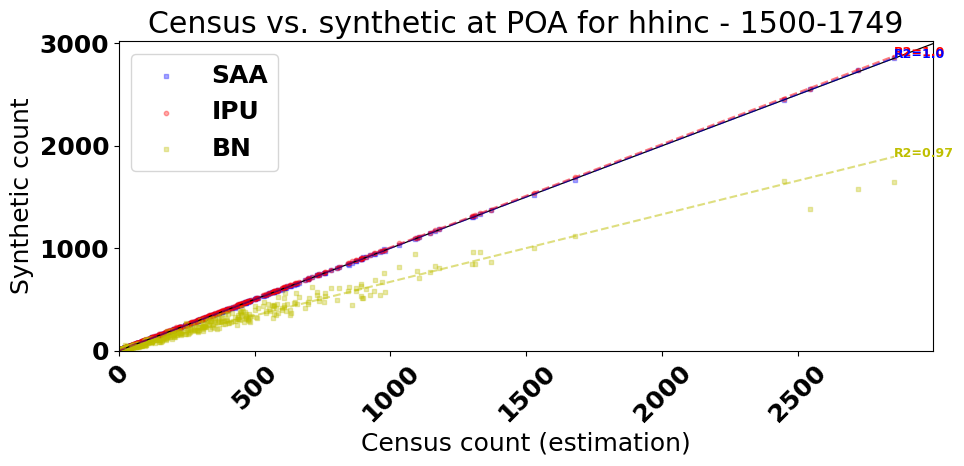

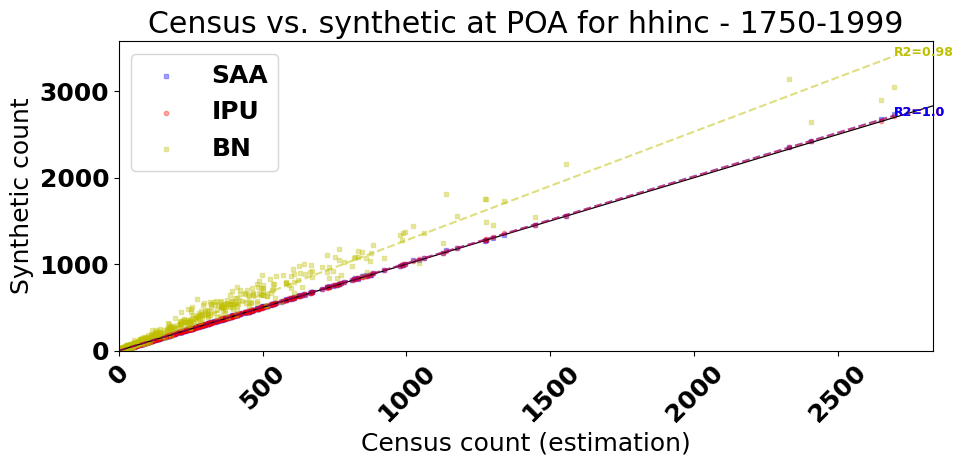

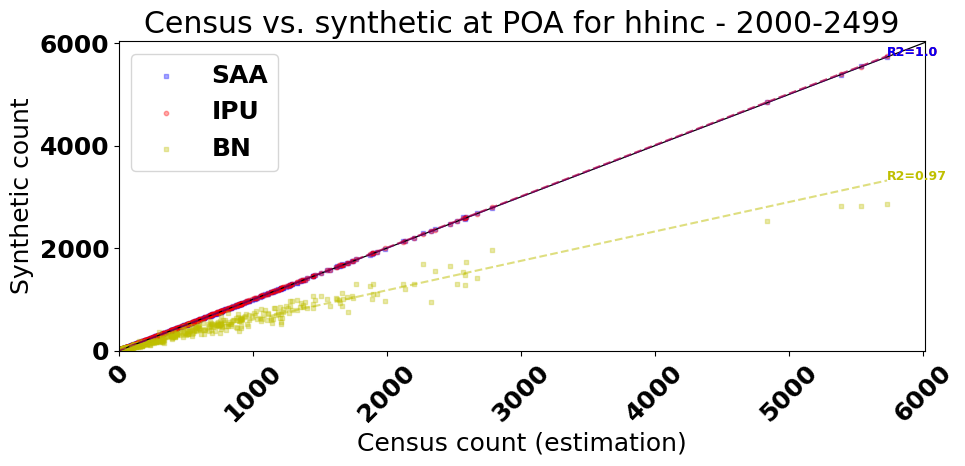

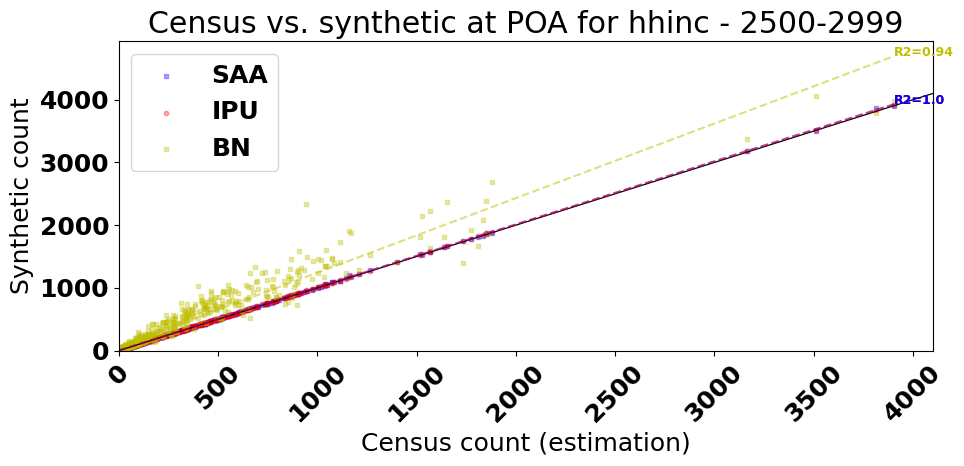

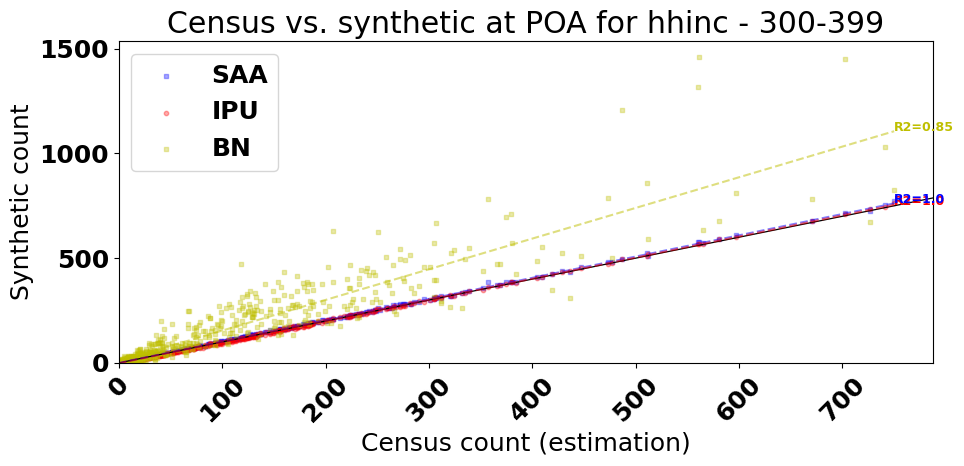

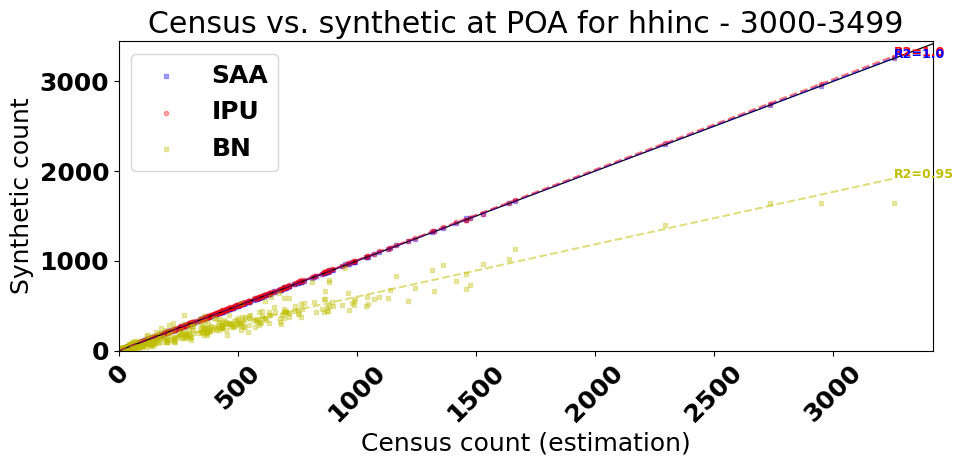

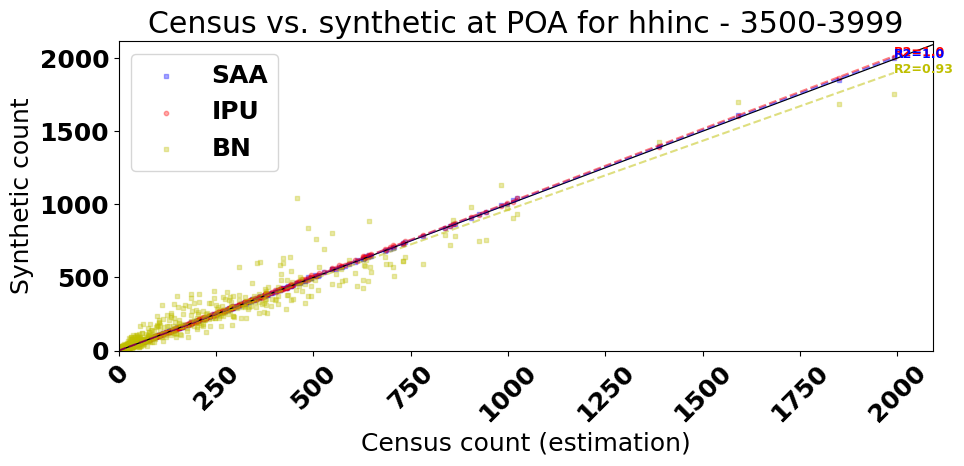

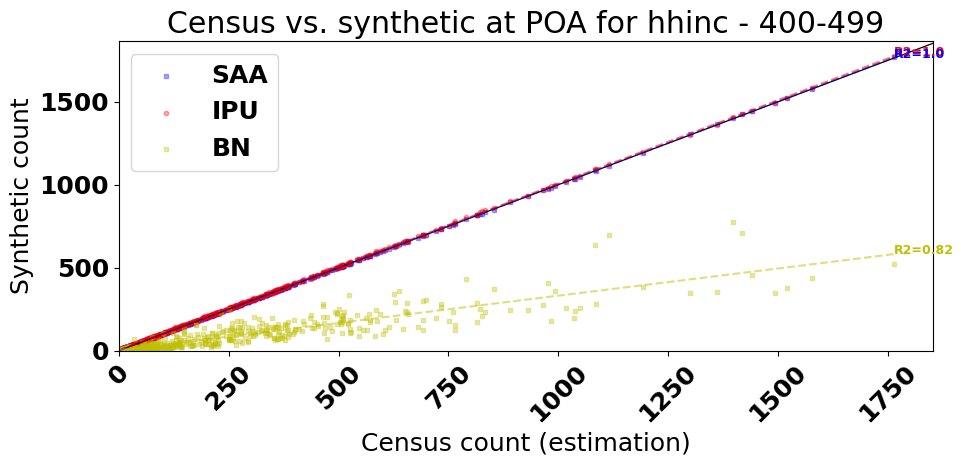

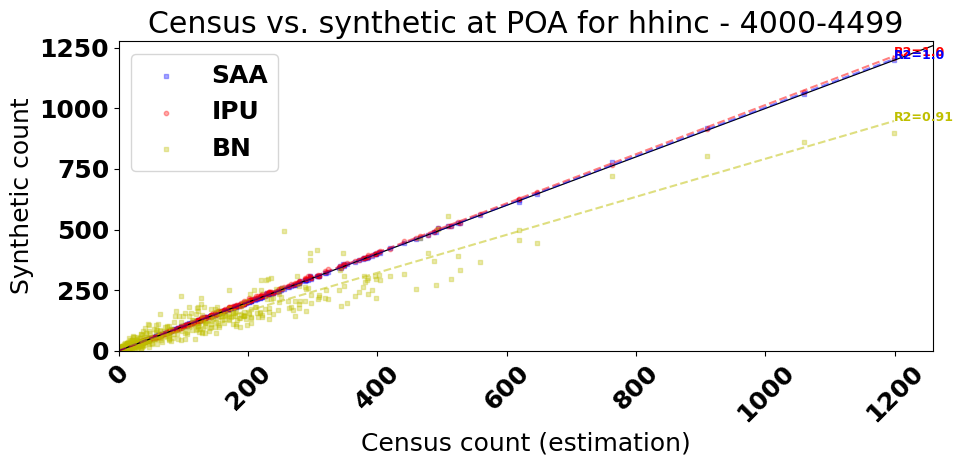

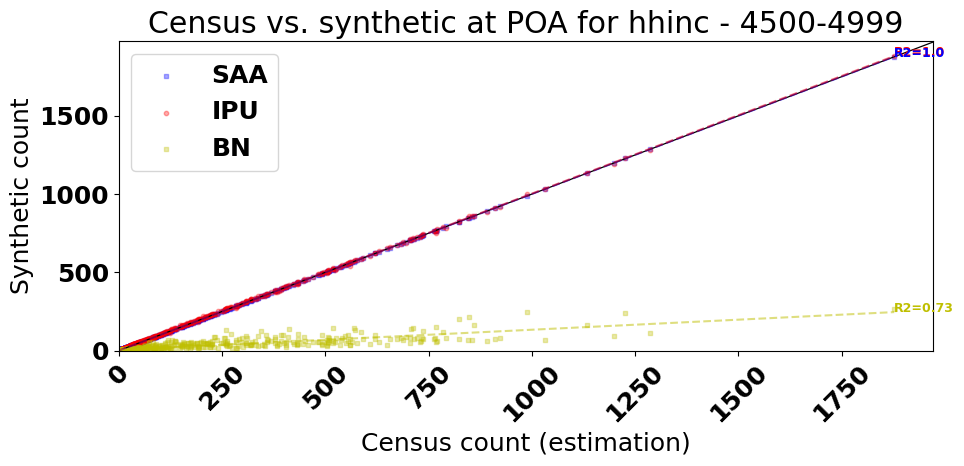

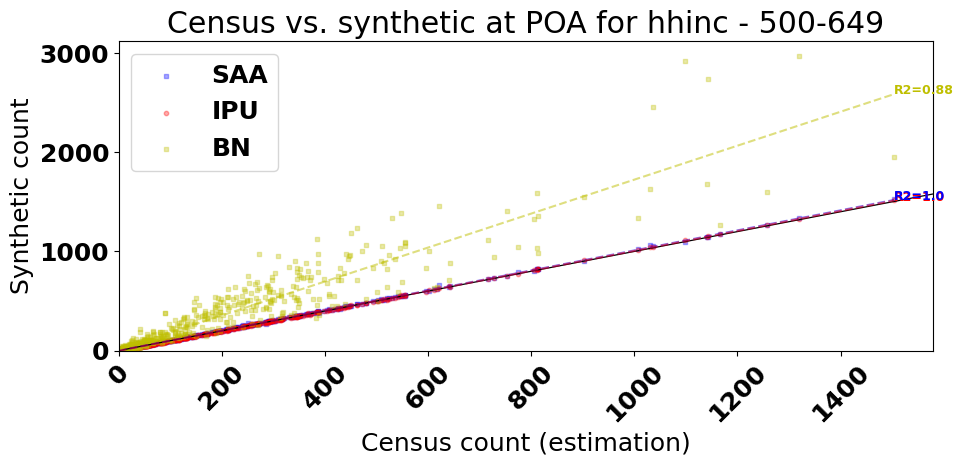

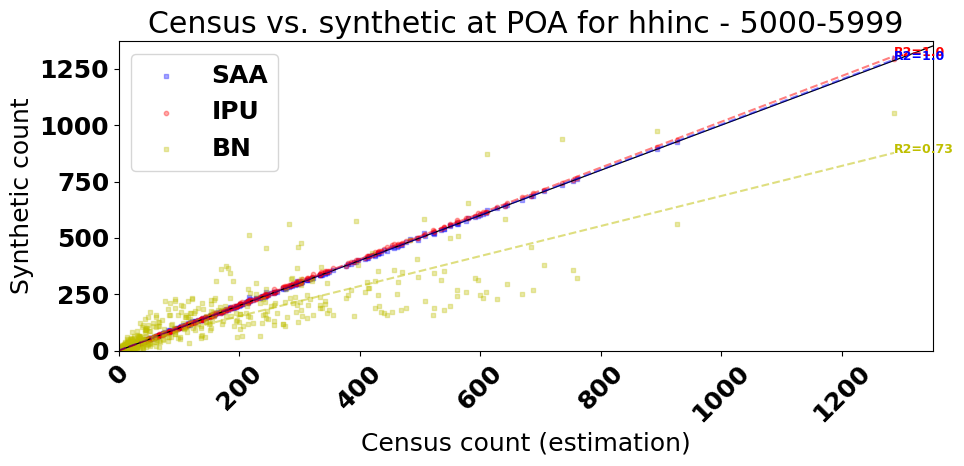

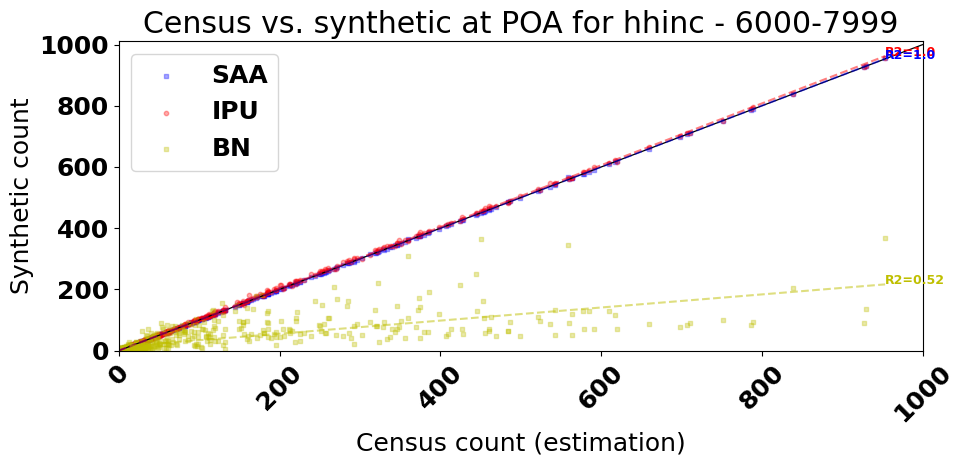

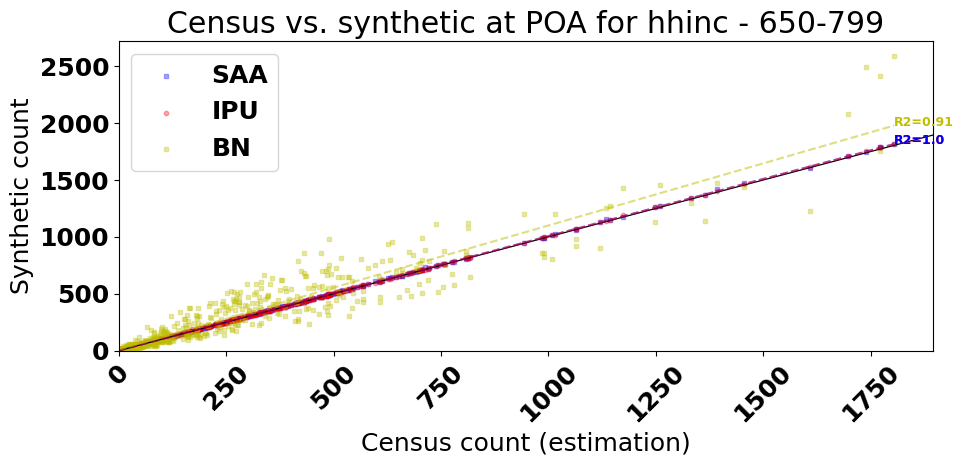

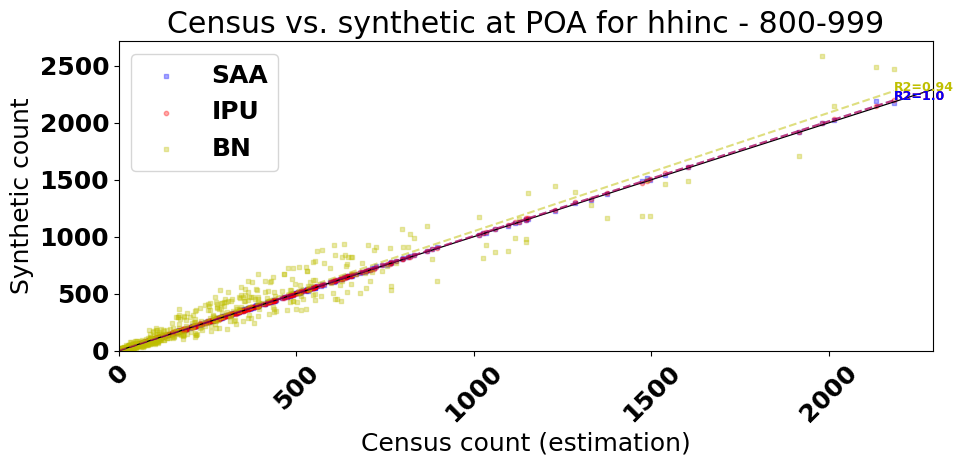

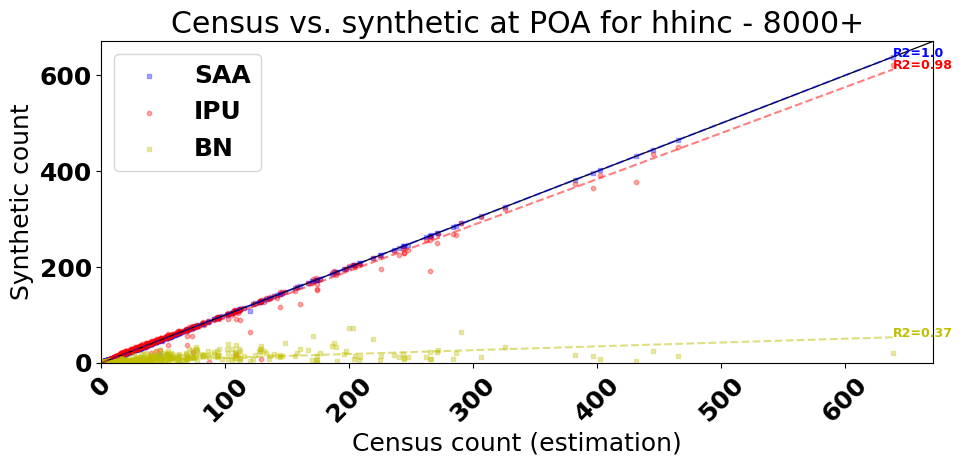

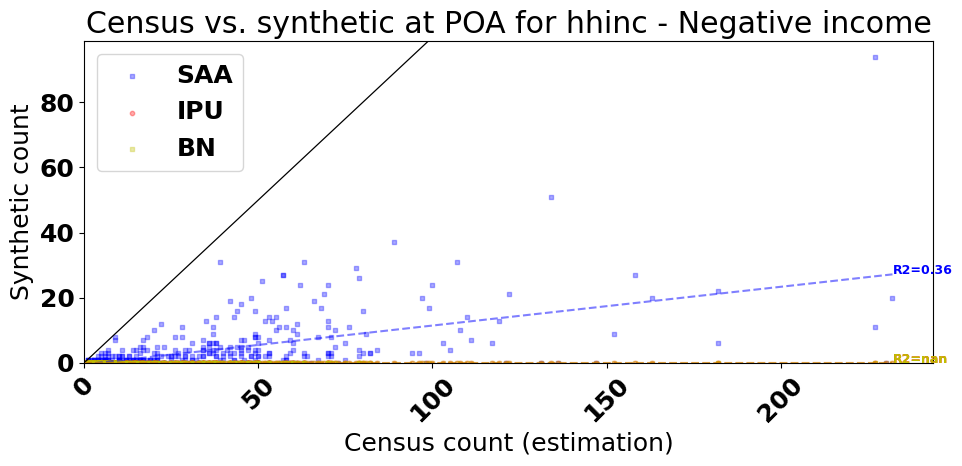

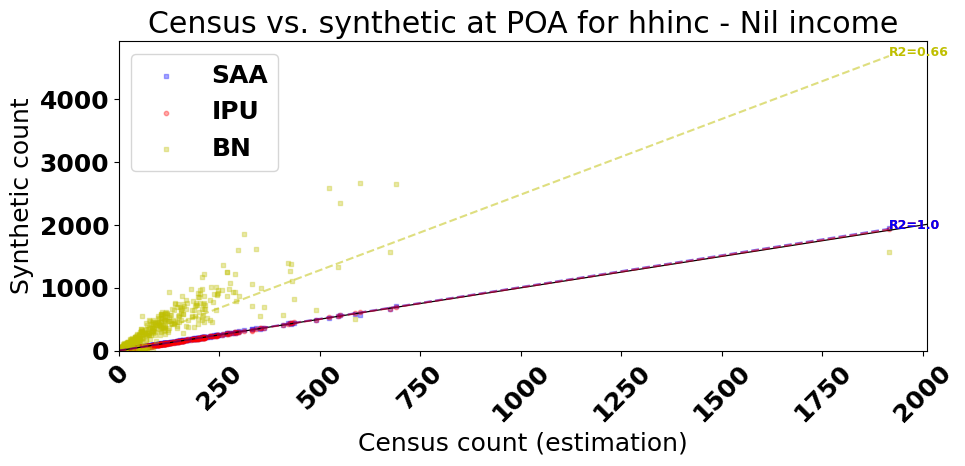

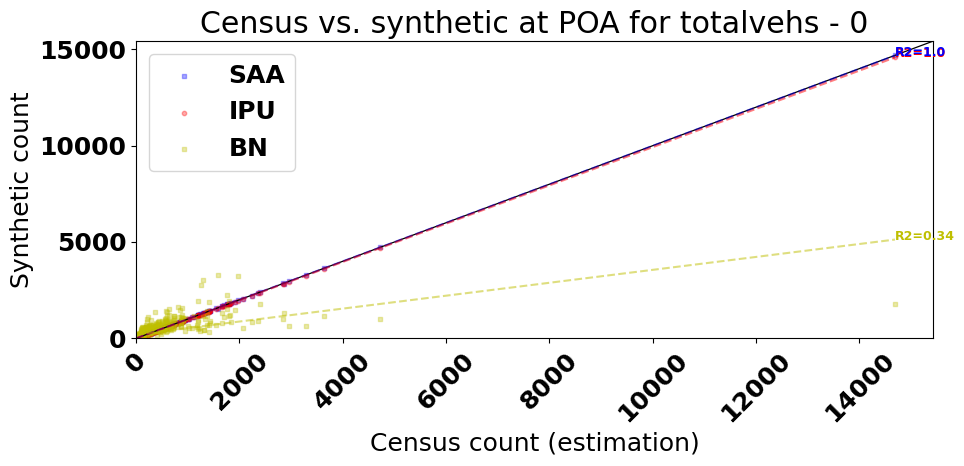

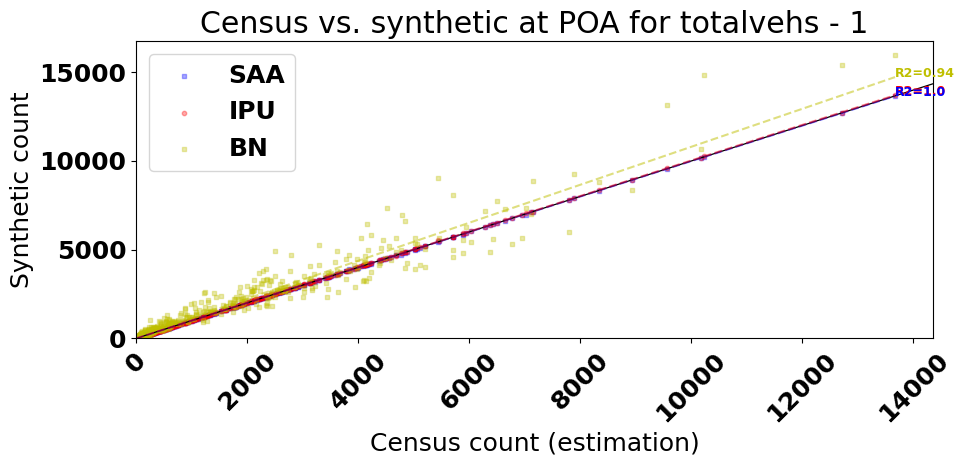

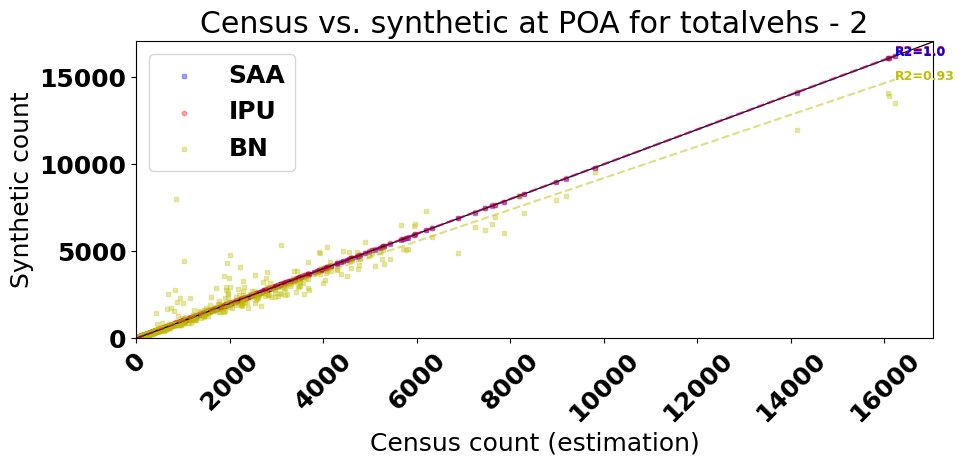

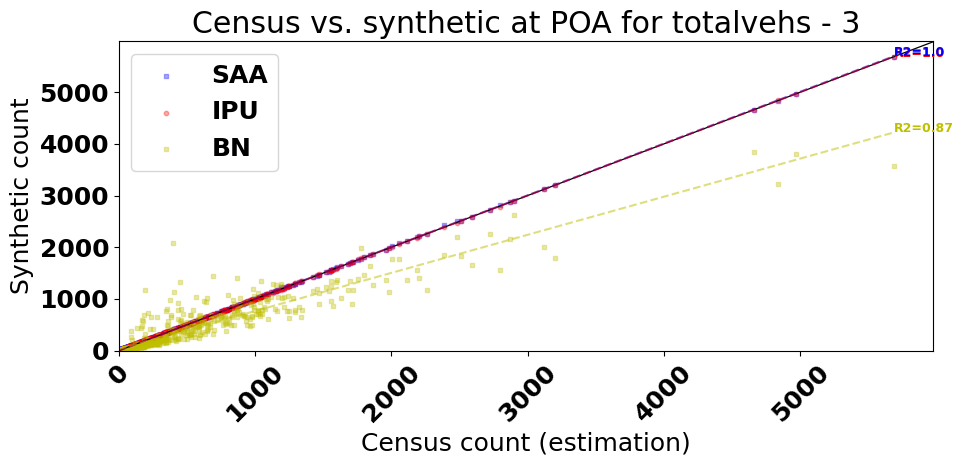

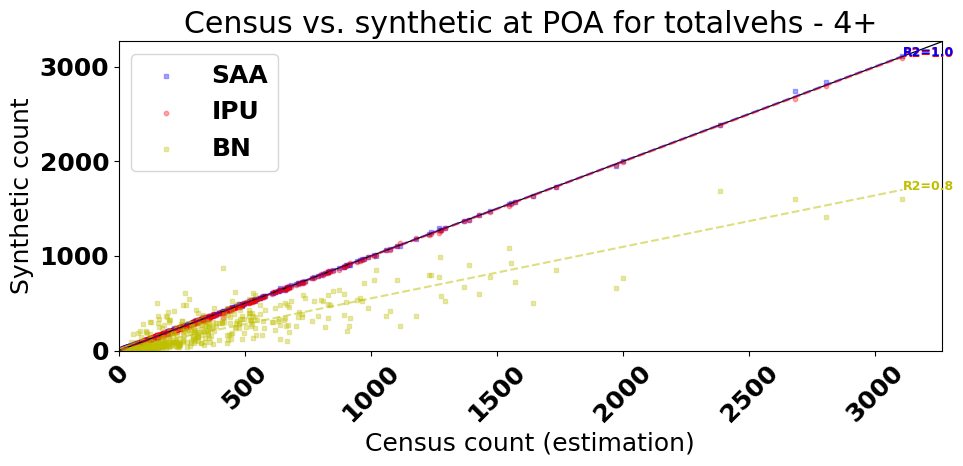

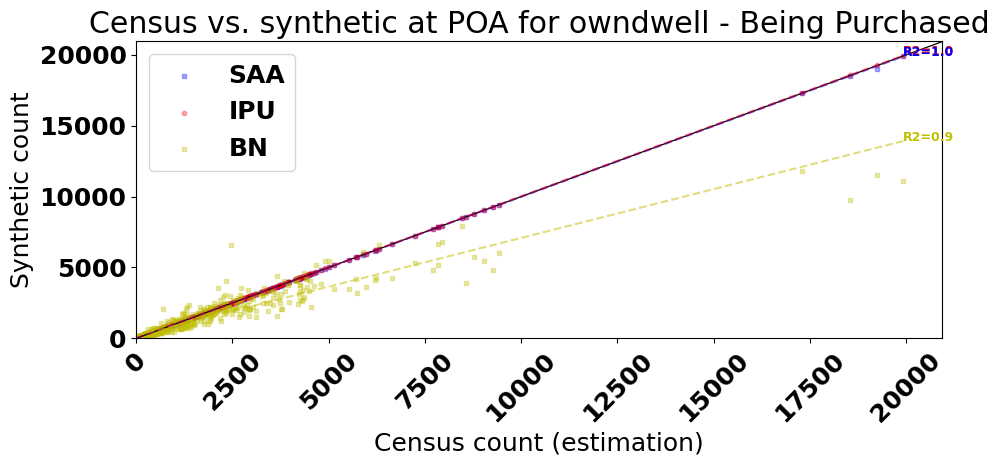

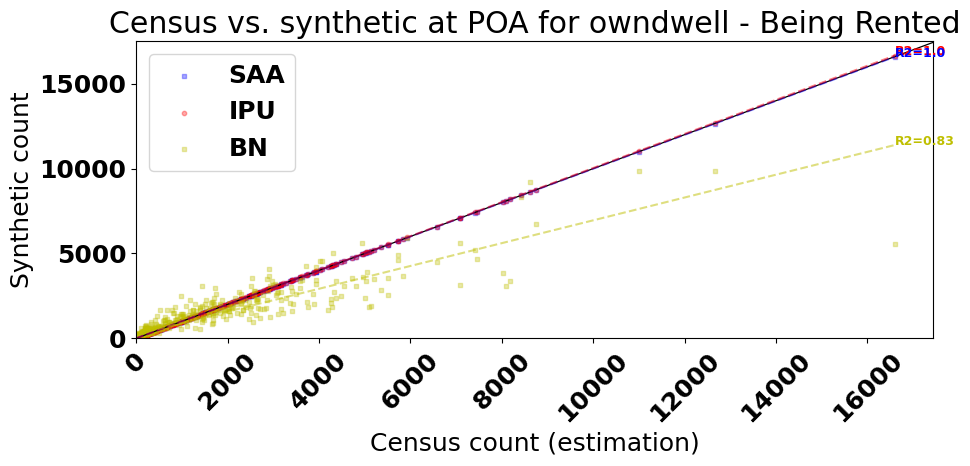

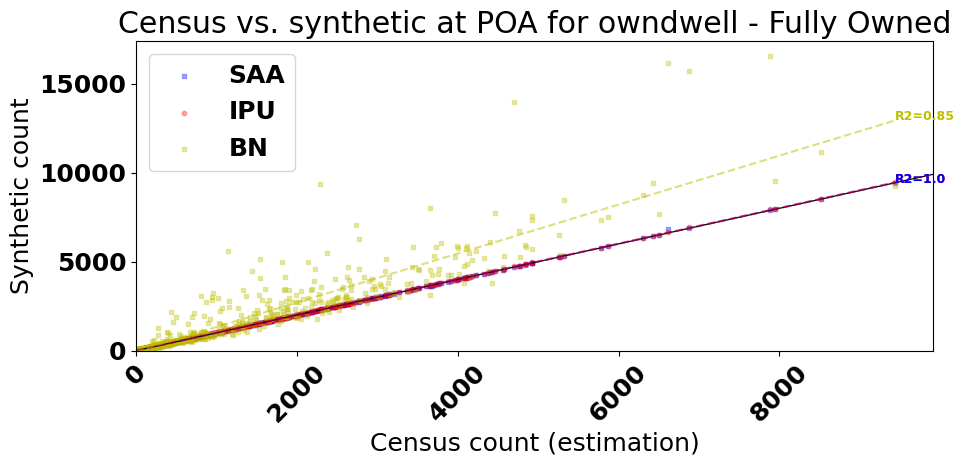

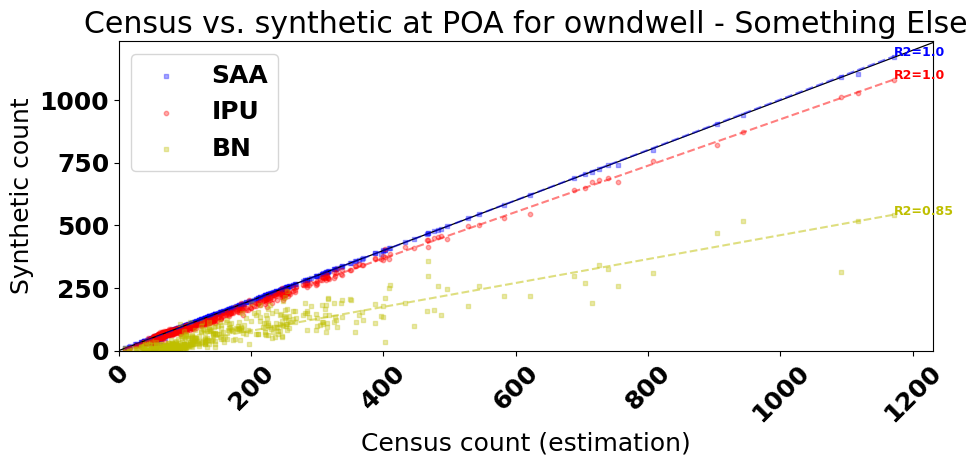

In [9]:
ls_atts = marg_hh.columns.get_level_values(0).unique()
for chosen_att in ls_atts:
    syn_check_saa = syn_hh_saa.groupby(chosen_att)[geo_lev].value_counts()
    syn_check_bn = syn_hh_bn.groupby(chosen_att)[geo_lev].value_counts()
    syn_check_ipf = syn_hh_ipf.groupby(chosen_att)[geo_lev].value_counts()
    att_df = marg_hh[marg_hh.columns[marg_hh.columns.get_level_values(0)==chosen_att]]
    att_df.index = att_df.index.astype(str)

    to_plot = {}
    for val in att_df.columns.get_level_values(1).unique():
        to_plot[val] = [[], [], [], []]
        for poa in att_df.index:
            to_plot[val][0].append(att_df.loc[poa][(chosen_att ,val)])
            if (val, poa) in syn_check_ipf.index:
                to_plot[val][1].append(syn_check_ipf[(val, poa)])
            else:
                to_plot[val][1].append(0)
            if (val, poa) in syn_check_saa.index:
                to_plot[val][2].append(syn_check_saa[(val, poa)])
            else:
                to_plot[val][2].append(0)
            if (val, poa) in syn_check_bn.index:
                to_plot[val][3].append(syn_check_bn[(val, poa)])
            else:
                to_plot[val][3].append(0)


    for val in att_df.columns.get_level_values(1):
        x = list(to_plot[val][0]),
        y_ipf = list(to_plot[val][1])
        y_saa = list(to_plot[val][2])
        y_bn = list(to_plot[val][3])

        fig = plt.figure(figsize = (10, 5))
        ax1 = fig.add_subplot(111)
        ax1.axline((0, 0), slope=1, c="black", linewidth=0.9)

        # Scatter data
        ax1.scatter(x, y_saa, s=10, c='b', marker="s", label='SAA', alpha=0.33)
        ax1.scatter(x, y_ipf, s=10, c='r', marker="o", label='IPU', alpha=0.33)
        ax1.scatter(x, y_bn, s=10, c='y', marker="s", label='BN', alpha=0.33)

        #add line of best fit to plot
        y_best_fit_ipf = np.poly1d(np.polyfit(x[0], y_ipf, 1))(np.unique(x[0]))
        y_best_fit_saa = np.poly1d(np.polyfit(x[0], y_saa, 1))(np.unique(x[0]))
        y_best_fit_bn = np.poly1d(np.polyfit(x[0], y_bn, 1))(np.unique(x[0]))
        ax1.plot(np.unique(x[0]), y_best_fit_saa, c='b', alpha=0.5, linestyle="--")
        ax1.plot(np.unique(x[0]), y_best_fit_ipf, c='r', alpha=0.5, linestyle="--")
        ax1.plot(np.unique(x[0]), y_best_fit_bn, c='y', alpha=0.5, linestyle="--")

        # Cal R squared
        r_s_ipf = r_squared(x[0], y_ipf, 1)["determination"]
        r_s_saa = r_squared(x[0], y_saa, 1)["determination"]
        r_s_bn = r_squared(x[0], y_bn, 1)["determination"]

        ax1.text(max(x[0]), max(y_best_fit_ipf), f"R2={round(r_s_ipf, 2)}", size=9, c="r")
        ax1.text(max(x[0]), max(y_best_fit_saa), f"R2={round(r_s_saa, 2)}", size=9, c="b")
        ax1.text(max(x[0]), max(y_best_fit_bn), f"R2={round(r_s_bn, 2)}", size=9, c="y")
        
        plt.xlabel(f"Census count (estimation)")
        plt.ylabel("Synthetic count")
        val = val.replace("/", "-")
        plt.title(f"Census vs. synthetic at {geo_lev} for {chosen_att} - {val}")
        ax1.set_xlim(left=0)
        ax1.set_ylim(bottom=0)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        # plt.show()
        plt.savefig(f'./output/imgs/{chosen_att}_{val}_census_compa.png')

In [10]:
poa_geo = gpd.read_file(os.path.join(data_dir,f"POA_2021_AUST_GDA2020_SHP.zip"), columns=["POA_CODE21"], engine="pyogrio")
poa_geo[geo_lev] = poa_geo["POA_CODE21"].astype(str)
poa_geo = poa_geo.set_index(geo_lev).drop(columns=["POA_CODE21"])

ls_metro_mel_raw = [
    (3000, 3211),
    (3335, 3336),
    (3338, 3338),
    (3427, 3429),
    (3750, 3752),
    (3754, 3755),
    (3759, 3761),
    (3765, 3775),
    (3781, 3787),
    (3788, 3815),
    (3910, 3920),
    (3926, 3944),
    (3975, 3978),
    (3980, 3980)
]
ls_metro_poa_all = []
for pair_range in ls_metro_mel_raw:
    ls_metro_poa_all += list(range(pair_range[0], pair_range[1]+1))
ls_metro_poa_all = [str(x) for x in ls_metro_poa_all]

In [11]:
def wrapper_produce_all_results(ls_syn_pop_name, benchmark_marg, geo_lev, geo_file, ls_sub_zones=None, to_plot=False, all_name=""):
    ls_atts = list(benchmark_marg.columns.get_level_values(0).unique())
    benchmark_marg.index = benchmark_marg.index.astype(str)

    ls_series_zones = []
    ls_series_atts = []
    ls_series_states = []
    ls_names = []
    for syn_pop, name in ls_syn_pop_name:
        ls_names.append(name)
        converted_m = convert_full_to_marg_count(syn_pop, geo_lev, [x for x in syn_pop if x not in ls_atts])
        diff_se_m = (converted_m - benchmark_marg)**2
        # diff_se_m = diff_se_m.fillna(1000000)
        # Drop the special case of negative income
        if all_name == "HH":
            diff_se_m = diff_se_m.drop(columns=[("hhinc", "Negative income")])
        # Process for zones
        zones_rmse = diff_se_m.mean(axis=1).apply(lambda x: np.sqrt(x))
        zones_rmse.name = name
        ls_series_zones.append(zones_rmse)
        # Process for atts
        atts_rmse = pd.Series(name=name)
        for att in ls_atts:
            sub_diff = diff_se_m[diff_se_m.columns[diff_se_m.columns.get_level_values(0)==att]]
            # sub_diff.columns = sub_diff.columns.droplevel(0)
            sum_sub = sub_diff.mean(axis=1).apply(lambda x: np.sqrt(x))
            atts_rmse.loc[att] = sum_sub.mean()
        ls_series_atts.append(atts_rmse)
        # Process for states
        states_rmse = diff_se_m.mean()
        states_rmse.name = name
        ls_series_states.append(states_rmse)
    fin_zones_df = pd.concat(ls_series_zones, axis=1)
    # Process for final score
    fin_rmse = fin_zones_df.mean()
    # Process to have geo info
    fin_zones_gdf = geo_file.merge(fin_zones_df, left_index=True, right_index=True)
    # Process for fin atts score
    fin_atts_df = pd.concat(ls_series_atts, axis=1)
    # Process for fin states score
    fin_states_df = pd.concat(ls_series_states, axis=1)
    if ls_sub_zones is None:
        fin_sub_zones = None
    else:
        fin_sub_zones = fin_zones_gdf[fin_zones_gdf.index.isin(ls_sub_zones)]
    
    if to_plot:
        if all_name == "HH":
            vmax = 50
        else:
            vmax = 10000
        for method in ls_names:
            ax_all = fin_zones_gdf.plot(column=method, legend=True, figsize=(20, 12), vmin=0, vmax=vmax, cmap="plasma")
            ax_all.set_title(f"All_VIC - {geo_lev} - {all_name}_RMSE_{method}")
            plt.savefig(f'./output/imgs/{all_name}_All_{geo_lev}_{method}_RMSE.png',bbox_inches='tight')
            if fin_sub_zones is not None:
                ax_sub = fin_sub_zones.plot(column=method, legend=True, figsize=(20, 12), vmin=0, vmax=vmax, cmap="plasma")
                ax_sub.set_title(f"Metro_VIC - {all_name}_RMSE_{method}")
                plt.savefig(f'./output/imgs/{all_name}_Metro_{geo_lev}_{method}_RMSE.png',bbox_inches='tight')
    return fin_zones_gdf, fin_sub_zones, fin_rmse, fin_atts_df, fin_states_df

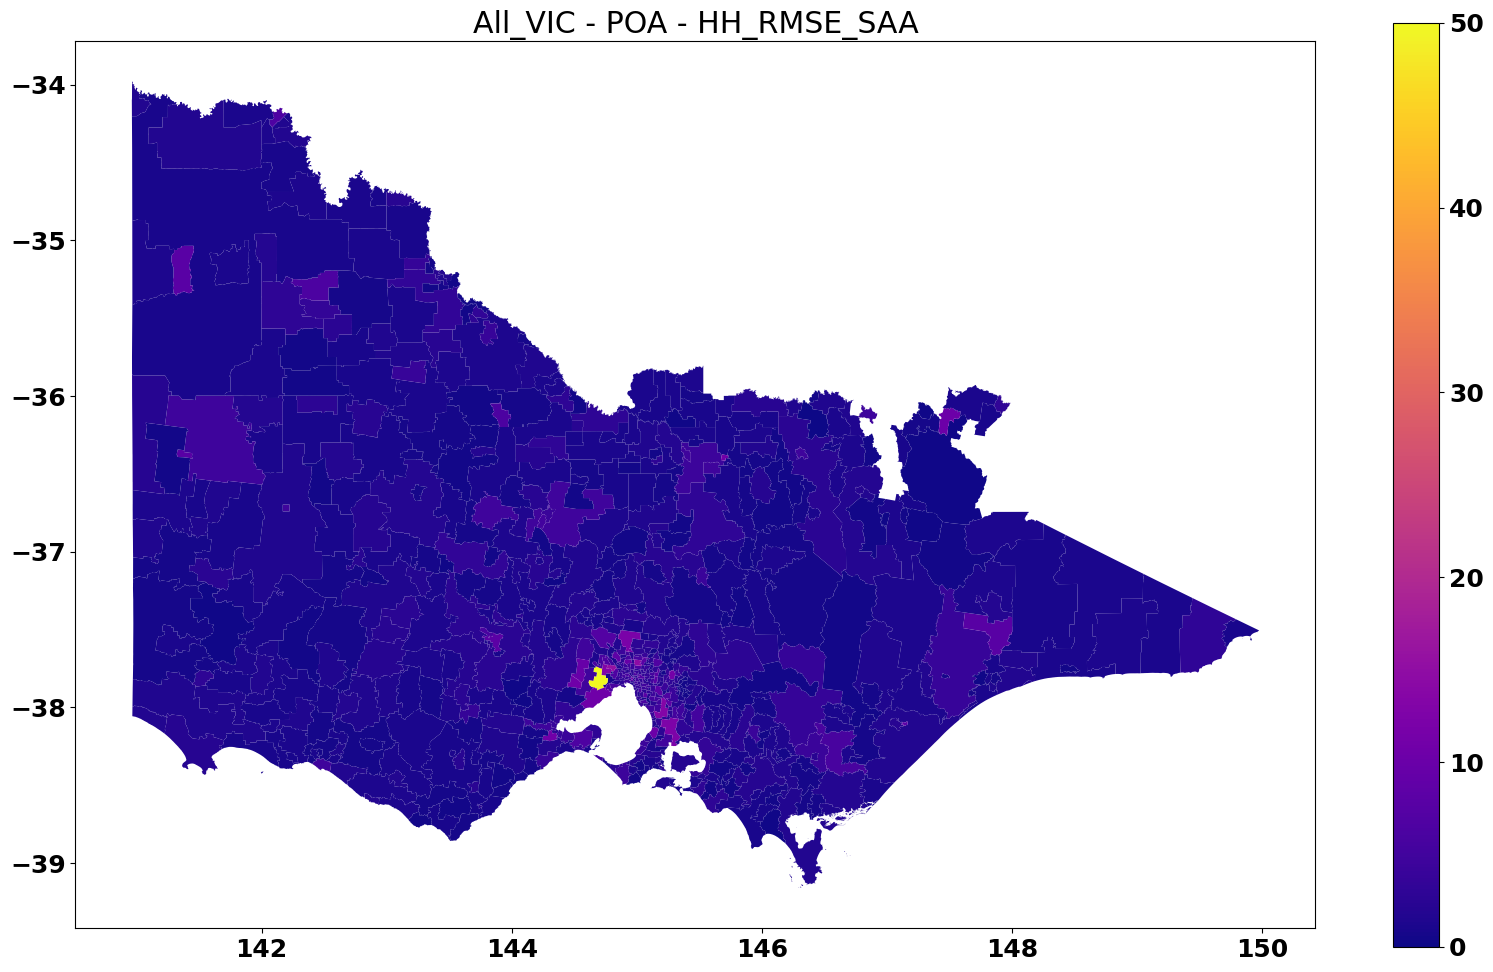

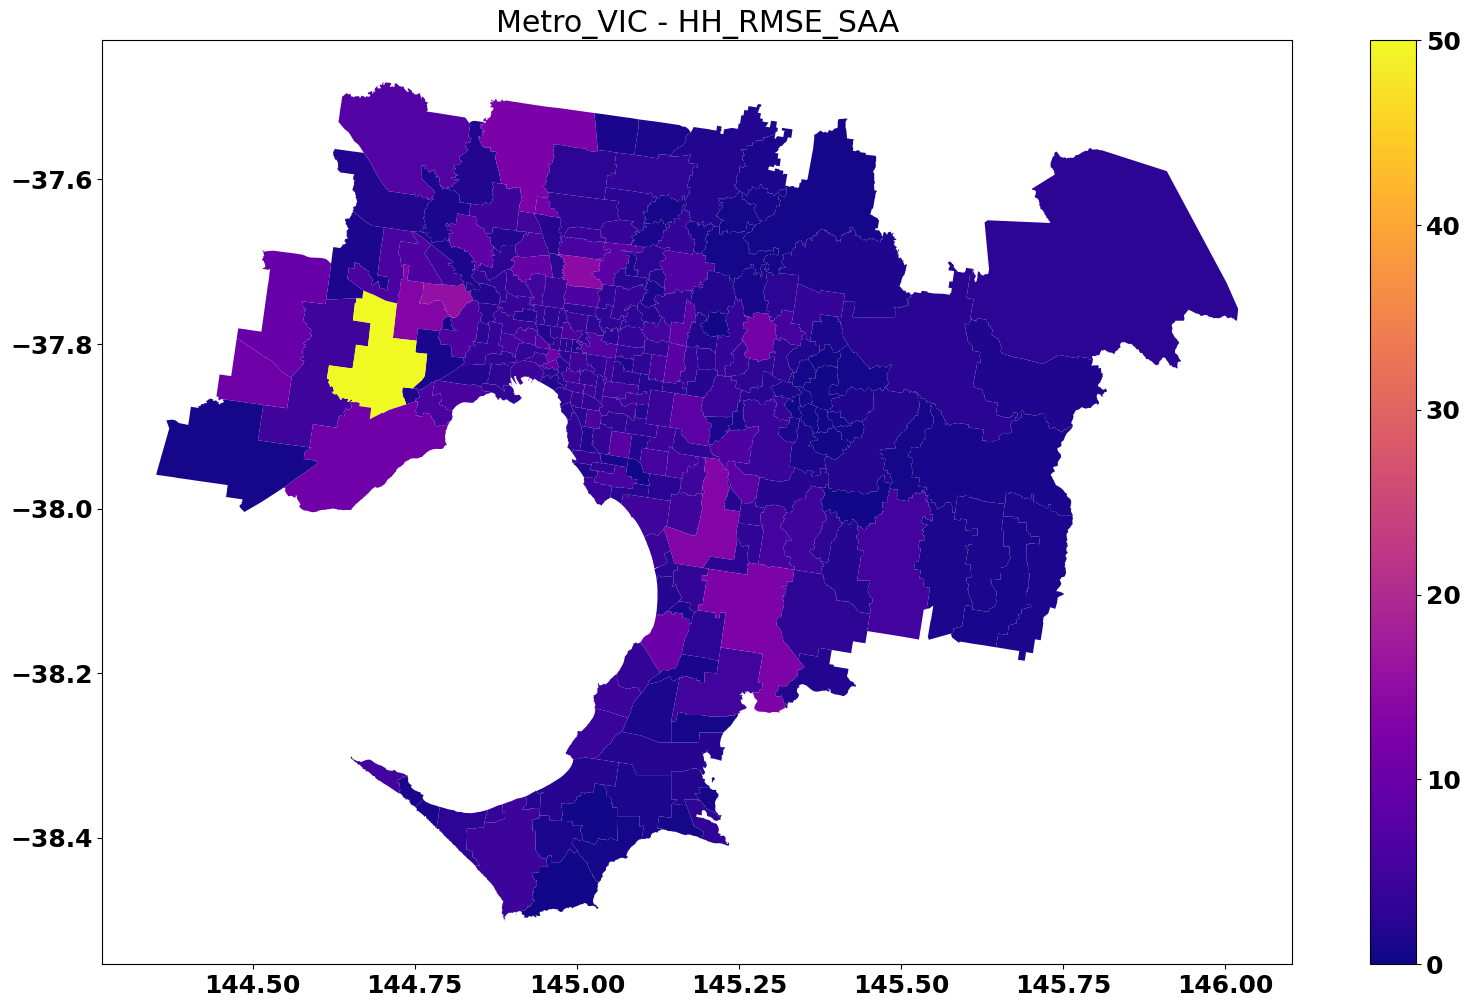

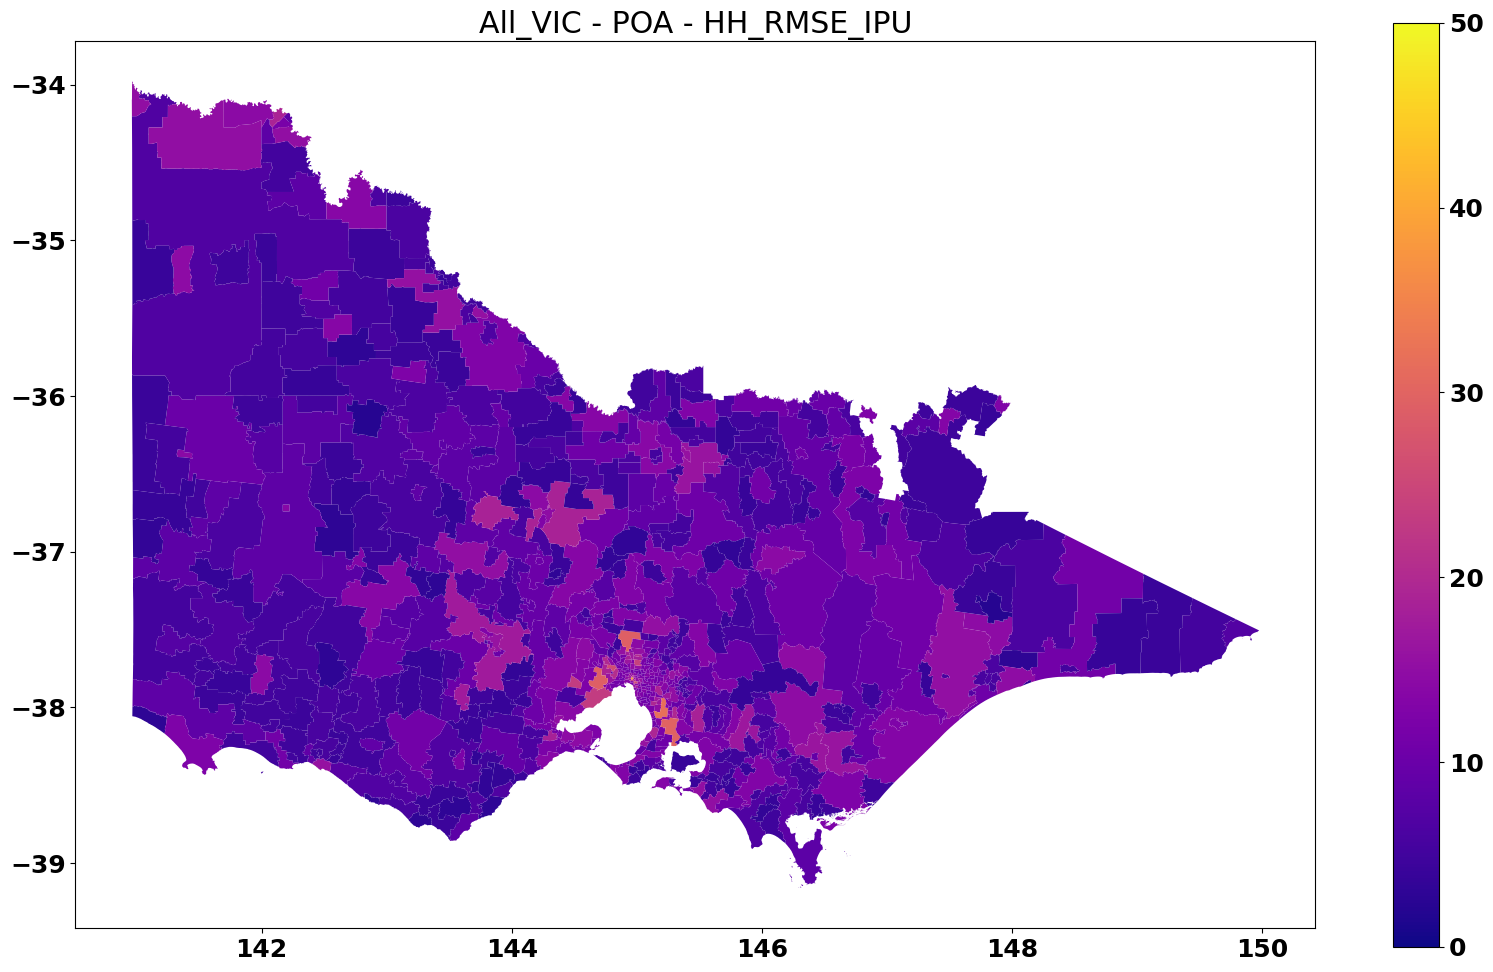

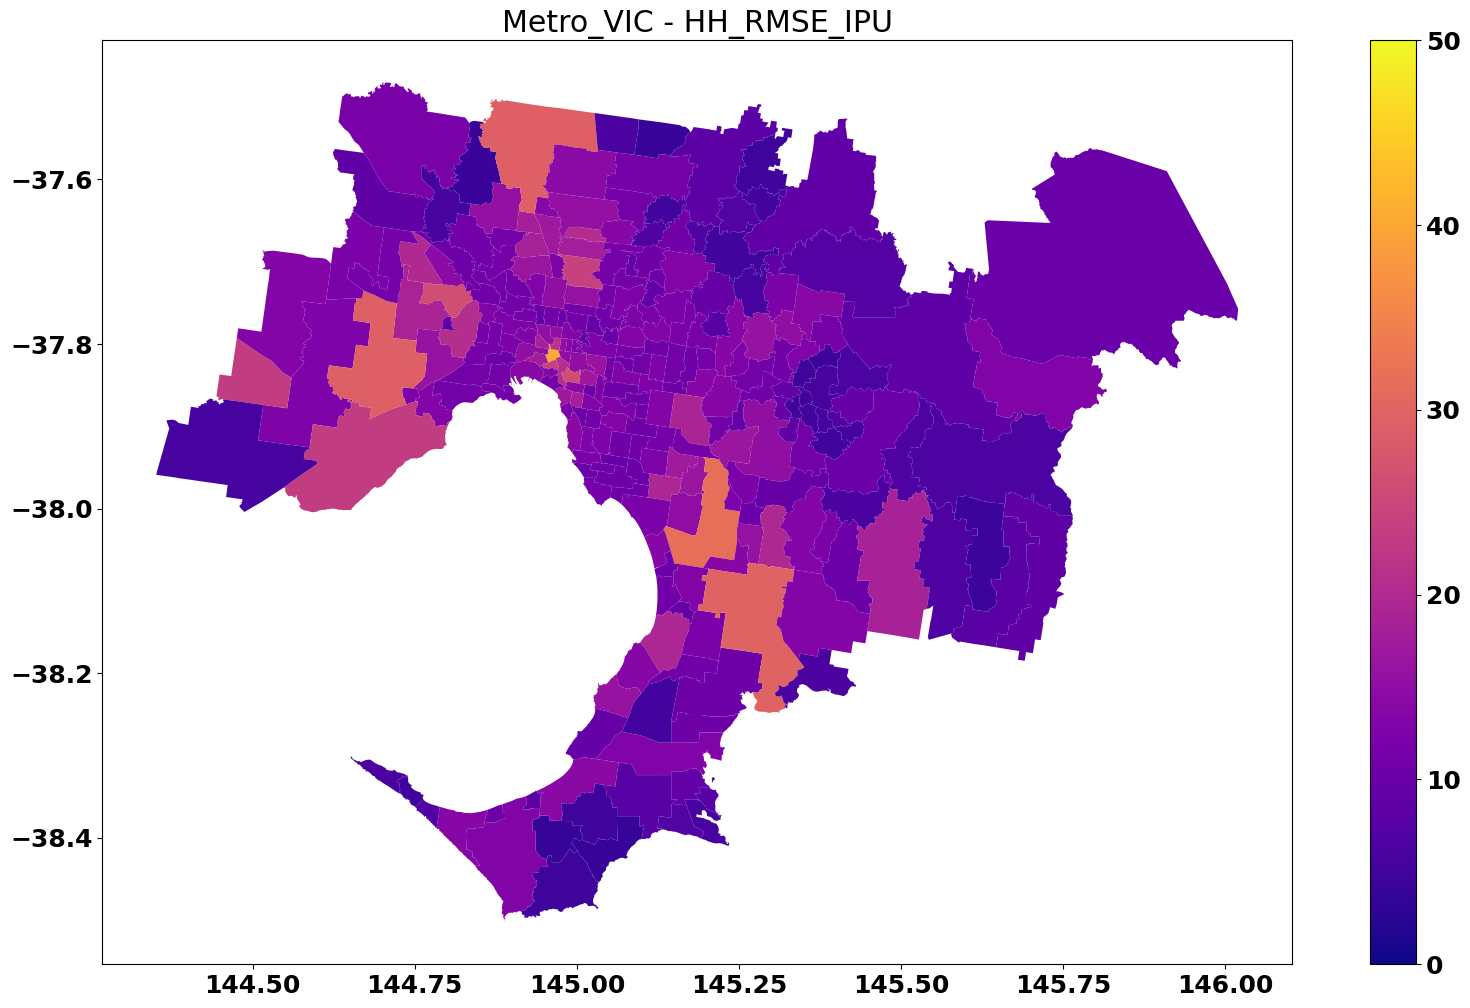

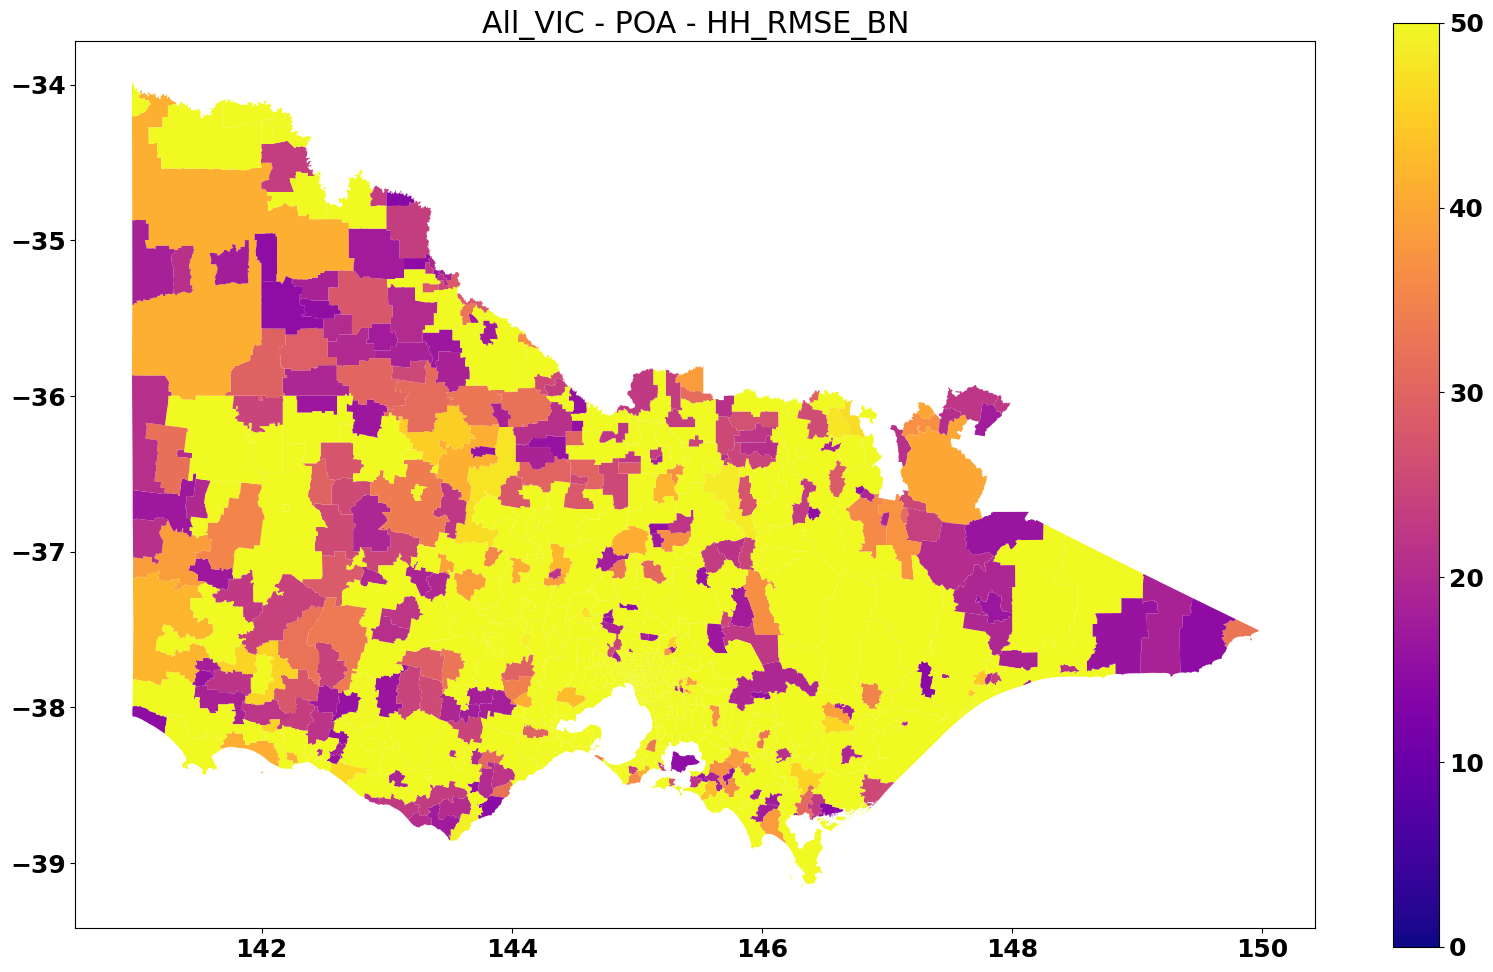

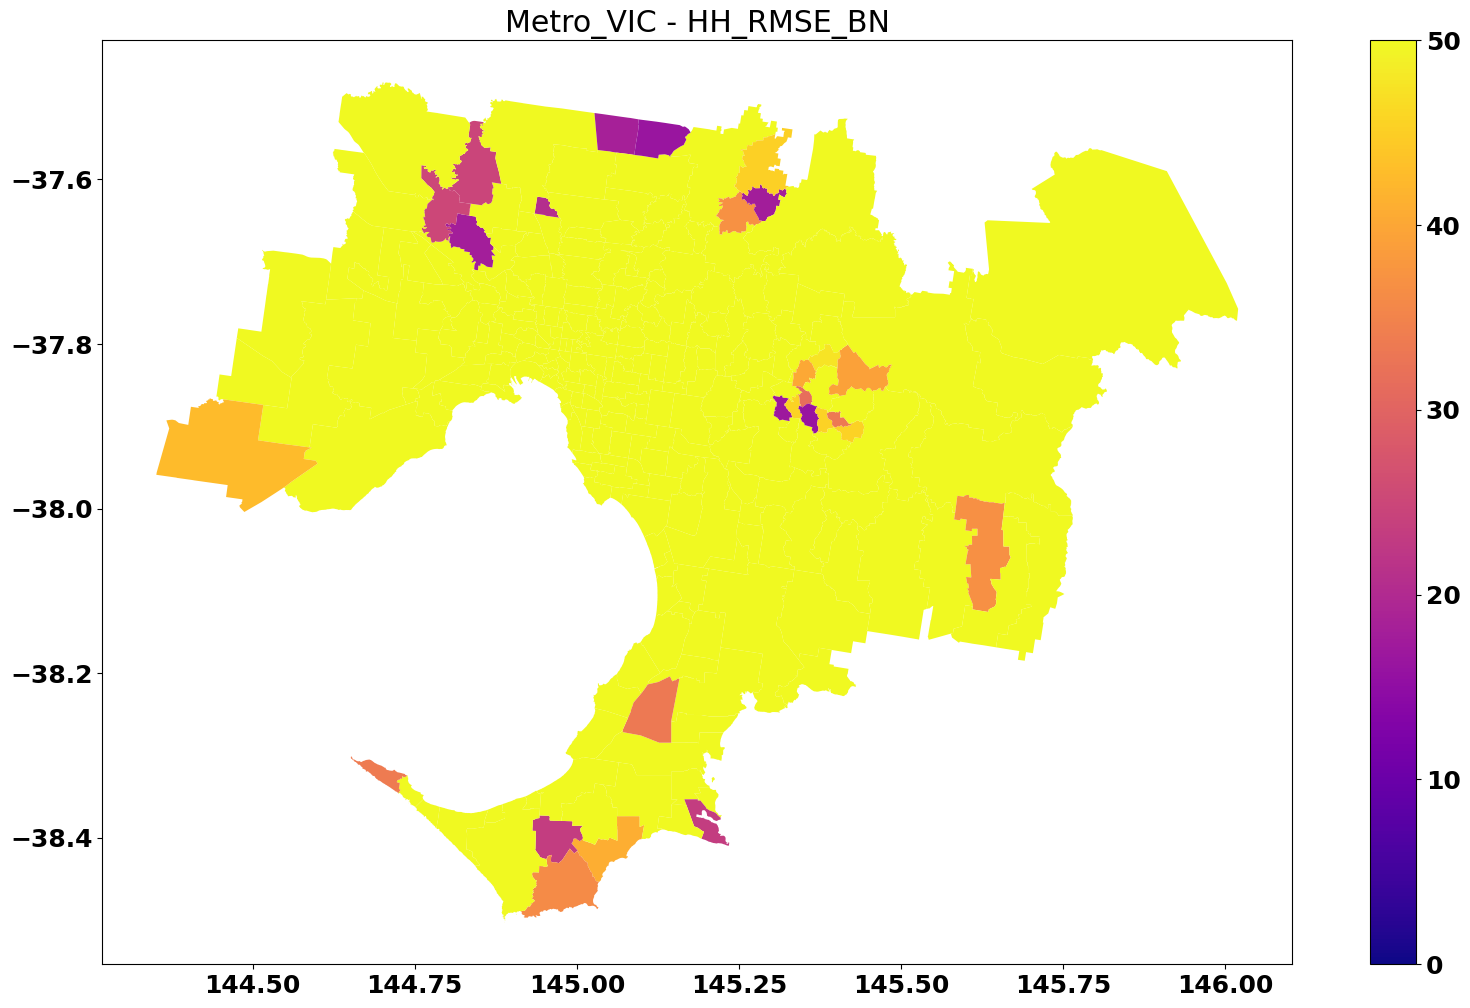

In [12]:
ls_syn_pop_hh = [
    (syn_hh_saa, "SAA"),
    (syn_hh_ipf, "IPU"),
    (syn_hh_bn, "BN")
]
hh_zones_gdf, hh_sub_zones, hh_rmse, hh_atts_df, hh_states_df = wrapper_produce_all_results(ls_syn_pop_hh, marg_hh, "POA", poa_geo, ls_sub_zones=ls_metro_poa_all, to_plot=True, all_name="HH")

In [13]:
hh_atts_df["SAA_to_IPU"] = (hh_atts_df["SAA"] - hh_atts_df["IPU"])/hh_atts_df["IPU"]
hh_atts_df["SAA_to_BN"] = (hh_atts_df["SAA"] - hh_atts_df["BN"])/hh_atts_df["BN"]

hh_states_df["SAA_to_IPF"] = (hh_states_df["SAA"] - hh_states_df["IPU"])/hh_states_df["IPU"]
hh_states_df["SAA_to_BN"] = (hh_states_df["SAA"] - hh_states_df["BN"])/hh_states_df["BN"]

In [14]:
hh_atts_df.index.name = "att"
hh_atts_df = hh_atts_df.reset_index()
hh_atts_df["type"] = "Household"
hh_atts_df = hh_atts_df.set_index(["type","att"])
hh_atts_df

SAA        IPU          BN  SAA_to_IPU  SAA_to_BN
type      att                                                              
Household hhsize     0.000000   9.036001  136.843834   -1.000000  -1.000000
          dwelltype  0.997103  16.355670  457.740522   -0.939036  -0.997822
          hhinc      2.032266   3.798842   95.536986   -0.465030  -0.978728
          totalvehs  2.313692   8.791307  208.464836   -0.736821  -0.988901
          owndwell   3.377500  12.002351  351.256591   -0.718597  -0.990385

In [15]:
hh_rmse

SAA      2.385922
IPU      9.228978
BN     231.599927
dtype: float64

In [16]:
# pp_atts_df.to_csv("./output/tables/pp_atts.csv")
# pp_states_df.to_csv("./output/tables//pp_states.csv")
# hh_states_df.to_csv("./output/tables/hh_states.csv")
# hh_atts_df.to_csv("./output/tables/hh_atts.csv")
# all_att_df.to_csv("./output/tables/all_atts.csv")

## Running to compare the census distributions

Maybe think about  calculating the JSD for census and seed data.

In [17]:
# Creating the marg version of the synthetic, this should make it easier
def create_syn_marg_data(syn_data, columns_census, index_census, geog):
    # process syn_data to dict
    ls_atts = list(columns_census.get_level_values(0).unique()) # gotta match between census and synthetic

    hold_dict = {}
    for att in ls_atts:
        sub_counts = syn_data[[geog, att]].value_counts()
        for comb in sub_counts.index:
            hold_dict[f"{comb[0]}_{att}_{comb[1]}"] = sub_counts[comb]
    
    fi_arr = [[] for _ in range(len(index_census))]
    for i, zone in enumerate(index_census):
        for col in columns_census:
            name = f"{zone}_{col[0]}_{col[1]}"
            val = hold_dict[name] if name in hold_dict else 0
            fi_arr[i].append(val)
    
    df_fi = pd.DataFrame(fi_arr, index=index_census, columns=columns_census)
    return df_fi

In [18]:
marg_syn_hh_saa = create_syn_marg_data(syn_hh_saa, marg_hh.columns, marg_hh.index, "POA")
marg_syn_hh_ipf = create_syn_marg_data(syn_hh_ipf, marg_hh.columns, marg_hh.index, "POA")
marg_syn_hh_bn = create_syn_marg_data(syn_hh_bn, marg_hh.columns, marg_hh.index, "POA")

In [19]:
def compare_vals_census(syn_marg_df, census_df):
    # We can loop through the each index to have the score comparison of each att at each zone
    # Then we can avg out to have the score for each att
    ls_atts = list(census_df.columns.get_level_values(0).unique()) # same between census and synthetic
    ls_zones = census_df.index
    dict_vals = {}
    for att in ls_atts:
        sub_syn = syn_marg_df[syn_marg_df.columns[syn_marg_df.columns.get_level_values(0)==att]].to_numpy()
        sub_census = census_df[census_df.columns[census_df.columns.get_level_values(0)==att]].to_numpy()
        for i in range(len(ls_zones)):
            dict_vals[f"{ls_zones[i]}_{att}"] = jensenshannon(sub_census[i], sub_syn[i], base=2)
    return dict_vals

a = compare_vals_census(marg_syn_hh_bn, marg_hh)
print(a)

{'3000_hhsize': 0.2910139992060863, '3002_hhsize': 0.26699159704153613, '3003_hhsize': 0.2330422278344683, '3004_hhsize': 0.2817012213119775, '3006_hhsize': 0.27704514358344756, '3008_hhsize': 0.2471992403819522, '3011_hhsize': 0.1220771651431088, '3012_hhsize': 0.06890645322774373, '3013_hhsize': 0.07014698318540548, '3015_hhsize': 0.0941256871378013, '3016_hhsize': 0.07745644323278131, '3018_hhsize': 0.08185208564196379, '3019_hhsize': 0.1462540224007916, '3020_hhsize': 0.12841932196379682, '3021_hhsize': 0.15242623658876875, '3022_hhsize': 0.1832541225568464, '3023_hhsize': 0.2229521247349077, '3024_hhsize': 0.2275929903449342, '3025_hhsize': 0.11498189050230131, '3026_hhsize': 0.34385113391584604, '3027_hhsize': 0.2708923465342927, '3028_hhsize': 0.08322439337731527, '3029_hhsize': 0.2473403908301625, '3030_hhsize': 0.16674965569315947, '3031_hhsize': 0.12919411922198717, '3032_hhsize': 0.06177670034081315, '3033_hhsize': 0.10595582606072099, '3034_hhsize': 0.10047849809665245, '30

In [20]:
compare_hh_saa = compare_vals_census(marg_syn_hh_saa, marg_hh)

compare_hh_ipf = compare_vals_census(marg_syn_hh_ipf, marg_hh)

compare_hh_bn = compare_vals_census(marg_syn_hh_bn, marg_hh)


In [21]:
import statistics as stat
ls_atts = list(marg_hh.columns.get_level_values(0).unique())
ls_data = []
for att in ls_atts:
    ls_com = []
    for com in [compare_hh_ipf, compare_hh_bn, compare_hh_saa]:
        ls_com_att = [com[x] for x in com if att in x and str(com[x]) != "nan" and str(com[x]) != "inf"]
        avg_val = stat.mean(ls_com_att)
        ls_com.append(avg_val)
    ls_data.append(ls_com)

hh_dist_atts = pd.DataFrame(ls_data, columns=[ "IPU", "BN", "SAA"], index=ls_atts)
hh_dist_atts["SAA_to_IPF"] = (hh_dist_atts["SAA"] - hh_dist_atts["IPU"])/hh_dist_atts["IPU"]
hh_dist_atts["SAA_to_BN"] = (hh_dist_atts["SAA"] - hh_dist_atts["BN"])/hh_dist_atts["BN"]
hh_dist_atts

IPU        BN       SAA  SAA_to_IPF  SAA_to_BN
hhsize     0.067388  0.265774  0.000000   -1.000000  -1.000000
dwelltype  0.072996  0.337283  0.006382   -0.912564  -0.981077
hhinc      0.096415  0.300836  0.068423   -0.290332  -0.772557
totalvehs  0.034415  0.212393  0.010208   -0.703389  -0.951938
owndwell   0.040947  0.268474  0.024868   -0.392681  -0.907374

In [22]:
# hh_dist_atts.to_csv("./output/tables/hh_dist_atts.csv")

In [23]:
syn_hh_bn

dwelltype         owndwell      hhinc totalvehs hhsize   POA  \
0        Flat or Apartment     Being Rented  1000-1249         0      1  3000   
1           Separate House  Being Purchased  1500-1749        4+      4  3064   
2        Flat or Apartment      Fully Owned    650-799         1      1  3182   
3           Separate House     Being Rented  1000-1249         2      4  3037   
4           Separate House  Being Purchased  3500-3999         3      4  3196   
...                    ...              ...        ...       ...    ...   ...   
2420215     Separate House  Being Purchased  2000-2499         3      3  3199   
2420216     Separate House  Being Purchased  1250-1499         2      4  3358   
2420217     Separate House  Being Purchased  2500-2999        4+      5  3038   
2420218     Separate House      Fully Owned  2000-2499        4+      4  3028   
2420219  Flat or Apartment     Being Rented  1000-1249         0      1  3012   

            hhid  
0              1  
1              2  
2              3  
3              4  
4              5  
...          ...  
2420215  2432023  
2420216  2432024  
2420217  2432025  
2420218  2432026  
2420219  2432027  

[2420220 rows x 7 columns]

In [24]:
syn_hh_saa

dwelltype         owndwell       hhinc totalvehs hhsize  \
0        Terrace/Townhouse   Something Else  Nil income         3      5   
1        Flat or Apartment  Being Purchased       1-149         0      1   
2        Flat or Apartment  Being Purchased       1-149         0      1   
3        Flat or Apartment  Being Purchased       1-149         0      1   
4        Flat or Apartment  Being Purchased       1-149         0      1   
...                    ...              ...         ...       ...    ...   
2420216     Separate House   Something Else     400-499         2      1   
2420217     Separate House   Something Else     800-999         2      1   
2420218              Other  Being Purchased     500-649         2      1   
2420219  Terrace/Townhouse  Being Purchased  Nil income         2      1   
2420220     Separate House  Being Purchased   1000-1249         3      1   

        Spouse Child Others Grandchild   POA     hhid  
0            1     3      0          0  3583  2334366  
1            0     0      0          0  3000  1162271  
2            0     0      0          0  3000  1163023  
3            0     0      0          0  3000  1163137  
4            0     0      0          0  3000  1163284  
...        ...   ...    ...        ...   ...      ...  
2420216      0     0      0          0  3996  2864678  
2420217      0     0      0          0  3996  2864679  
2420218      0     0      0          0  3996  2864680  
2420219      0     0      0          0  3996  2864681  
2420220      0     0      0          0  3996  2864682  

[2420221 rows x 11 columns]

In [25]:
syn_hh_ipf

serialno sample_geog          dwelltype         owndwell  \
0        Y13H0420209           2  Flat or Apartment     Being Rented   
1        Y13H0420209           2  Flat or Apartment     Being Rented   
2        Y13H0420209           2  Flat or Apartment     Being Rented   
3        Y13H0420209           2  Flat or Apartment     Being Rented   
4        Y13H0420209           2  Flat or Apartment     Being Rented   
...              ...         ...                ...              ...   
2420216  Y18H3290418           2     Separate House      Fully Owned   
2420217  Y13H0570327           2     Separate House  Being Purchased   
2420218  Y15H1290115           2     Separate House     Being Rented   
2420219  Y15H1480112           2     Separate House  Being Purchased   
2420220  Y12H0100501           2     Separate House      Fully Owned   

             hhinc totalvehs hhsize cat_id   POA     hhid  
0            1-149         0      1      1  3000        0  
1            1-149         0      1      1  3000        1  
2            1-149         0      1      1  3000        2  
3            1-149         0      1      1  3000        3  
4            1-149         0      1      1  3000        4  
...            ...       ...    ...    ...   ...      ...  
2420216  1250-1499         0      2   3562  3996  2420216  
2420217  1500-1749         2      4   8008  3996  2420217  
2420218    500-649         0      2   3801  3996  2420218  
2420219  5000-5999         2      3   6028  3996  2420219  
2420220    300-399         3      1   1494  3996  2420220  

[2420221 rows x 10 columns]